This notebook contains the step-by-step calculations of k-seq, there is another script (working on it) to perform the whole k-seq pipeline

In [5]:
import sys
import numpy as np
# add package directory to the top of sys.path
if np.sum([dirc.find('k-seq') >= 0 for dirc in sys.path]) == 0:
    sys.path = ['/home/yuning/Work/k-seq/src/'] + sys.path

import util
import importlib
import k_seq.data.pre_processing as pre_processing
import k_seq.data.analysis as analysis
importlib.reload(pre_processing)# refresh data module
importlib.reload(analysis)# refresh data module

<module 'k_seq.data.analysis' from '/home/yuning/Work/k-seq/src/k_seq/data/analysis.py'>

# Generate a table of all ribozymes to fit
- ribozymes that are detected in initial pool and at least one of the k-seq samples
- input:
  - Directories for count files of initial pool and other k-seq samples
  - A tuple includes the valid k-seq samples
  
- output:
  - A list of sample info
  > sampleInfo = [
  > {
  > }
  > ]
  - A list of sequences for fitting
  > seqToFit = [
  > 
  > {
  > 
  > }
  > 
  > ]




In [6]:
sample_set = pre_processing.load_count_files(
    file_root='/mnt/storage/projects/k-seq/input/byo_counts/',
    pattern='.txt',
    name_pattern='counts-[{bfo}{rep}].txt',
)

IndexError: list index out of range

In [ ]:
spike_in_amounts = []
for i in range(4):
    spike_in_amounts += [4130, 1240, 826, 413, 207, 82.6, 41.3]
for sample in zip(sample_set, spike_in_amounts):
    print("{}: {} fmol".format(sample[0].name, sample[1]))

sample_set = k_seq.data.pre_processing.get_quant_factors(
    sample_set=sample_set,
    max_dist=2,
    max_dist_to_survey=10,
    spike_in='AAAAACAAAAACAAAAACAAA',
    spike_in_amounts=spike_in_amounts
)

In [10]:
from importlib import reload
import k_seq.k_seq as k_seq
reload(k_seq)

root = '/mnt/storage/projects/ribozyme_predict/data/count-file/'
kSeqList = ['counts-1A.txt','counts-1B.txt','counts-1C.txt','counts-1D.txt','counts-1E.txt','counts-1F.txt',
            'counts-2A.txt','counts-2B.txt','counts-2C.txt','counts-2D.txt','counts-2E.txt','counts-2F.txt',
            'counts-3A.txt','counts-3B.txt','counts-3C.txt','counts-3D.txt','counts-3E.txt','counts-3F.txt',
            'counts-4A.txt','counts-4B.txt','counts-4C.txt','counts-4D.txt','counts-4E.txt','counts-4F.txt']
r5Dirc = 'R5c-counts.txt'

sampleToCount = [
    [1, 2, 3, 4, 5, 6],
    [7, 8, 10, 11, 12],
    [13, 14, 15],
    [19, 20, 21, 23]
]

seqToFit, initTotal, seqToFitTotal = k_seq.get_seqToFit(initDirc=root+r5Dirc,
                                     sampleDircList=[root + dirc for dirc in kSeqList],
                                     validSampleList=sampleToCount)
util.dump_pickle(data=seqToFit,
                 dirc='/mnt/storage/projects/ribozyme_predict/data/k_seq/seqRawCount_select3Reps.pkl',
                 log='The seqToFit with only seq raw counts, selected three reps (all from first three except 50 nM), config added',
                 overwrite=True)

Candidate sequences imported from initial pool
Surveying sequences in sample /mnt/storage/projects/ribozyme_predict/data/count-file/counts-1A.txt ...
Surveying sequences in sample /mnt/storage/projects/ribozyme_predict/data/count-file/counts-1B.txt ...
Surveying sequences in sample /mnt/storage/projects/ribozyme_predict/data/count-file/counts-1C.txt ...
Surveying sequences in sample /mnt/storage/projects/ribozyme_predict/data/count-file/counts-2D.txt ...
Surveying sequences in sample /mnt/storage/projects/ribozyme_predict/data/count-file/counts-2E.txt ...
Surveying sequences in sample /mnt/storage/projects/ribozyme_predict/data/count-file/counts-2F.txt ...
Surveying sequences in sample /mnt/storage/projects/ribozyme_predict/data/count-file/counts-3A.txt ...
Surveying sequences in sample /mnt/storage/projects/ribozyme_predict/data/count-file/counts-3B.txt ...
Surveying sequences in sample /mnt/storage/projects/ribozyme_predict/data/count-file/counts-3C.txt ...
Surveying sequences in sam

# Normalize based on total counts in the sample and the qFactor

In [121]:
'''
Because of the assumption of high deviation in pipetting spike-in, we asssume the q-factor should be same for replicates in the same concentration, by using the mean of valid rounds except those obvious outliers
'''
import numpy as np
import util
from importlib import reload

def plot_qFactor():
    import matplotlib.pyplot as plt

qFactor = util.load_pickle('/mnt/storage/projects/ribozyme_predict/k_seq/qFactorList_ext_edit2_new.pkl')
sampleInfo = util.load_pickle('/mnt/storage/projects/ribozyme_predict/k_seq/sampleInfo.pkl')

for i in range(4):
    print('%.2f \t %.2f \t %.2f \t %.2f \t %.2f \t %.2f' %(qFactor[i*6+0][0], qFactor[i*6+1][0], qFactor[i*6+2][0], qFactor[i*6+3][0], qFactor[i*6+4][0], qFactor[i*6+5][0]))

qFactorCurated = np.array([1/2000] + 
                          [np.mean(1/np.array([44.00, 33.57, 44.71, 62.94])) for _ in range(6)] +
                          [np.mean(1/np.array([7.11, 5.23])) for _ in range(6)] +
                          [np.mean(1/np.array([6.49, 7.57, 4.51])) for _ in range(6)] + 
                          [np.mean(1/np.array([1.50, 2.21, 1.76, 1.36])) for _ in range(6)])
qFactorCurated = 1/qFactorCurated
util.dump_pickle(data=qFactorCurated,
                 dirc='/mnt/storage/projects/ribozyme_predict/k_seq/qFactorCurated_edit2_new.pkl',
                 log='New qFactor (reciprical of the old one), with external standard sequences within edit distance 2, averaged on selected rounds',
                 overwrite=True)
sampleTotals = np.array([sample['total'] for sample in sampleInfo])

qFactorList_ext_edit2_new.pkl:
The NEW q_factor (reciprical of the old one) only based on external spike-in, within edit distance 2, using k_seq.k_seq.get_q_factor()
sampleInfo.pkl:
sample information surveyed on all samples, INCLUDING the inital pool
44.00 	 20.73 	 33.57 	 44.71 	 77.55 	 62.94
7.11 	 5.23 	 0.40 	 80029.30 	 80339.30 	 22235.79
6.49 	 7.57 	 4.51 	 0.78 	 15.34 	 1.32
1.50 	 2.21 	 1.76 	 0.38 	 1.36 	 0.26
Data has been saved to /mnt/storage/projects/ribozyme_predict/k_seq/qFactorCurated_edit2_new.pkl


In [123]:
import k_seq.k_seq as k_seq

seqToFit = util.load_pickle('/mnt/storage/projects/ribozyme_predict/k_seq/seqRawCount.pkl')
qFactorCurated = util.load_pickle('/mnt/storage/projects/ribozyme_predict/k_seq/qFactorCurated_edit2_new.pkl')
seqToFit = k_seq.get_normalized_fraction(seqToFit, sampleTotals=sampleTotals, qFactors=qFactorCurated)
util.dump_pickle(data=seqToFit,
                 dirc='/mnt/storage/projects/ribozyme_predict/k_seq/seqToFit_edit2.pkl',
                 log='seqToFit with normalized reacted fraction, with new qFactors edit distance 2',
                 overwrite=False)

seqRawCount.pkl:
The seqToFit with only seq raw counts, config added
qFactorCurated_edit2_new.pkl:
New qFactor (reciprical of the old one), with external standard sequences within edit distance 2, averaged on selected rounds
Data has been saved to /mnt/storage/projects/ribozyme_predict/k_seq/seqToFit_edit2.pkl


qFactorCurated_edit0_new.pkl:
New qFactor (reciprical of the old one), averaged on selected rounds


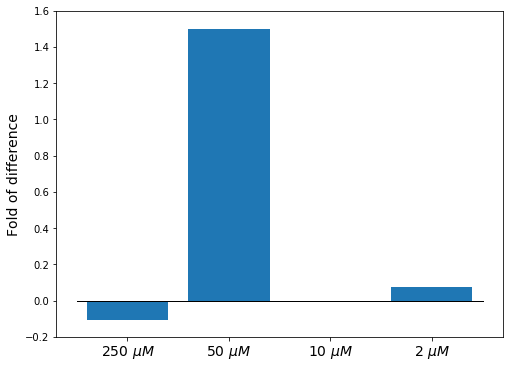

In [274]:
qFactorAbe = [0.0005,
              0.023823133, 0.023823133, 0.023823133, 0.023823133, 0.023823133, 0.023823133,
              0.062784812, 0.062784812, 0.062784812, 0.062784812, 0.062784812, 0.062784812,
              0.159915207, 0.159915207, 0.159915207, 0.159915207, 0.159915207, 0.159915207,
              0.53032596, 0.53032596, 0.53032596, 0.53032596, 0.53032596, 0.53032596]
qFactorCurated = util.load_pickle('/mnt/storage/projects/ribozyme_predict/k_seq/qFactorCurated_edit0_new.pkl')
mask = [False,
        True, False, False, False, False, False,
        True, False, False, False, False, False,
        True, False, False, False, False, False,
        True, False, False, False, False, False]

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)
ax.bar(x=[1, 2, 3, 4], height=((1/qFactorCurated - qFactorAbe)/qFactorAbe)[mask])
ax.set_xticks([1, 2, 3, 4])
ax.plot([0.5, 4.5], [0, 0], 'k-', lw=1)
ax.set_ylim([-0.2, 1.6])
ax.set_ylabel('Fold of difference', fontsize=14)
ax.set_xticklabels([r'250 $\mu M$', r'50 $\mu M$', r'10 $\mu M$', r'2 $\mu M$'], fontsize=14)
plt.show()

array([ 0.00000000e+00, -1.05388017e-01, -1.05388017e-01, -1.05388017e-01,
       -1.05388017e-01, -1.05388017e-01, -1.05388017e-01,  1.49909604e+00,
        1.49909604e+00,  1.49909604e+00,  1.49909604e+00,  1.49909604e+00,
        1.49909604e+00,  1.89198492e-04,  1.89198492e-04,  1.89198492e-04,
        1.89198492e-04,  1.89198492e-04,  1.89198492e-04,  7.51386636e-02,
        7.51386636e-02,  7.51386636e-02,  7.51386636e-02,  7.51386636e-02,
        7.51386636e-02])

In [124]:
seqToFit_old = util.load_pickle('/mnt/storage/projects/ribozyme_predict/k_seq/seqToFit.pkl')
seqToFit_corrected = util.load_pickle('/mnt/storage/projects/ribozyme_predict/k_seq/seqToFit_2.pkl')
seqToFit_edit2 = util.load_pickle('/mnt/storage/projects/ribozyme_predict/k_seq/seqToFit_edit2.pkl')

seqToFit.pkl:
seqToFit, with reacted fraction
seqToFit_2.pkl:
seqToFit, with normalized reacted fraction, with corrected qFactors, edit distance 0
seqToFit_edit2.pkl:
seqToFit with normalized reacted fraction, with new qFactors edit distance 2


In [125]:
normError = []
for i in range(len(seqToFit_corrected)):
    normError += list((seqToFit_old[i]['reactedFrac'] - seqToFit_corrected[i]['reactedFrac'])/seqToFit_old[i]['reactedFrac'])
normError = [i for i in normError if ~np.isnan(i)]

In [128]:
max(normError)

0.04898082387670778

In [129]:
normError = []
for i in range(len(seqToFit_corrected)):
    normError += list((seqToFit_corrected[i]['reactedFrac'] - seqToFit_edit2[i]['reactedFrac'])/seqToFit_corrected[i]['reactedFrac'])
normError = [i for i in normError if ~np.isnan(i)]

In [132]:
max(normError)

0.06081772123552124

In [59]:
reload(k_seq)
xdata = np.array([0.00025 for i in range(6)] + 
                 [0.00005 for i in range(6)] +
                 [0.00001 for i in range(6)] +
                 [0.000002 for i in range(6)])
for i in range(1000):
    if np.sum(seqToFit[i]['config'])>6:
        break
seq = k_seq.fitting(seqToFit[i], xdata)

In [64]:
np.sum([1 for seq in seqToFit if np.sum(seq['config']) > 1])

94208

In [78]:
seqToFit = util.load_pickle('/mnt/storage/projects/ribozyme_predict/data/k_seq/seqToFit.pkl')

seqToFit.pkl:
seqToFit, with reacted fraction


In [79]:
len(seqToFit)

403901

# Results check

In [1]:
import util
fittingRes = util.load_pickle('/mnt/storage/projects/ribozyme_predict/k_seq/fittingRes_abe_deep.pkl')

fittingRes_abe_deep.pkl:
Fitting results of Abe's data, including the CI 95 estimation using 1000 bootstrap, on Pod (40 cores)


In [10]:
def filter_fn1(res):
    if len(res['stdevs']) == 1:
        return False
    elif 0.01 <= res['stdevs'][2]/res['params'][2] <=10:
        return True
    else:
        return False

def filter_fn2_1(res):
    if len(res['stdevs']) == 1:
        return False
    elif res['ci95'][2][0]>=0.5*res['params'][2] and res['ci95'][2][1]<=1.5*res['params'][2]:
        return True
    else:
        return False
    
def filter_fn2_2(res):
    if len(res['stdevs']) == 1:
        return False
    elif res['ci95'][2][0]>=0.5*res['ci95'][2][3] and res['ci95'][2][1]<=1.5*res['ci95'][2][3]:
        return True
    else:
        return False

def filter_fn3(res):
    if len(res['stdevs']) == 1:
        return False
    elif res['ci95'][2][0]>=0.9*res['params'][2] and res['ci95'][2][1]<=1.1*res['params'][2]:
        return True
    else:
        return False

print('Total unique ribozymes: %i' %len(fittingRes))
print('Ribozymes can estimate mean: %i' %np.sum([1 for res in fittingRes if ~np.isnan(res['params'][2])]))
print('Ribozymes can perform bootstrapping for CI estimation: %i' %np.sum([1 for res in fittingRes if len(res['stdevs'])>1]))
print('Ribozymes has pct std in [0.01, 10]: %i' %np.sum([1 for res in fittingRes if filter_fn1(res)]))
print('Ribozymes has p2.5 >= 0.5 Mean and p97.5<=1.5 Mean: %i' %np.sum([1 for res in fittingRes if filter_fn2_1(res)]))
print('Ribozymes has p2.5 >= 0.5 Bootstrapped Mean and p97.5<=1.5 Bootstrapped Mean: %i' %np.sum([1 for res in fittingRes if filter_fn2_2(res)]))
print('Ribozymes has p2.5 >= 0.9 Mean and p97.5<=1.1 Mean: %i' %np.sum([1 for res in fittingRes if filter_fn3(res)]))
print('Ribozymes with >=6 samples detected: %i' %np.sum([1 for res in fittingRes if np.sum(res['config'])>=6]))

Total unique ribozymes: 403901
Ribozymes can estimate mean: 403651
Ribozymes can perform bootstrapping for CI estimation: 93958
Ribozymes has pct std in [0.01, 10]: 85290
Ribozymes has p2.5 >= 0.5 Mean and p97.5<=1.5 Mean: 44977
Ribozymes has p2.5 >= 0.5 Bootstrapped Mean and p97.5<=1.5 Bootstrapped Mean: 39869
Ribozymes has p2.5 >= 0.9 Mean and p97.5<=1.1 Mean: 19208
Ribozymes with >=6 samples detected: 28132


In [26]:
for res in fittingRes:
    if len(res['stdevs'])>1:
        if np.isnan(res['stdevs'][2]):
            print(res)

In [24]:
counter = 0
for res in fittingRes:
    if len(res['stdevs']) > 1:
        print(res)
        counter += 1
    if counter == 1:
        break

{'seq': 'GGGGGATTATCCTGGTCAAGT', 'rawCounts': [1, nan, nan, nan, nan, nan, nan, nan, nan, nan, 1, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 1, nan, nan, nan], 'config': [0, 1, 0, 1], 'id': 6, 'reactedFrac': array([1.        ,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.01068277,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.00216008,        nan,        nan,        nan]), 'r2': 0.9177047565893623, 'params': [0.8703103386377097, 5.767356497603878, 5.019389986474026], 'stdevs': array([ 0.06036342, 10.04329714, 10.29941882]), 'ci95': array([[ 0.84736107,  0.9952448 ],
       [ 5.22282813, 25.85650679],
       [ 4.98397302, 25.60290657]])}


In [22]:
filter_fn = lambda res: (np.sum(res['config'])>=2)and(~np.isnan(res['params'][0]))
np.sum([1 for res in fittingRes if filter_fn(res)])

93950

## Characterization
### Coverage of the k_seq

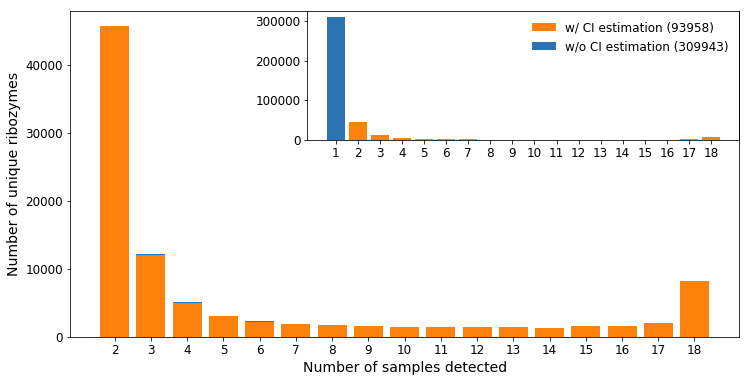

In [12]:
def survey_coverage(fittingRes):
    surveyRes = [[0, 0] for i in range(18)]
    for res in fittingRes:
        if len(res['stdevs'])>1:
            surveyRes[np.sum(res['config'])-1][0] += 1
        else:
            surveyRes[np.sum(res['config'])-1][1] += 1
    return surveyRes


def coverage_plot(surveyRes):
    import matplotlib.pyplot as plt
    import plot
    
    surveyRes = np.array(surveyRes).T
    fig = plt.figure(figsize=[12,6])
    ax = fig.add_subplot(111)
    pos = [i+1 for i in range(18)][1:]
    ax.bar(pos, surveyRes[0][1:], color='#FC820D')
    ax.bar(pos, surveyRes[1][1:], bottom=surveyRes[0][1:], color='#2C73B4')
    ax.set_xticks(pos)
    plot.set_ticks_size(ax)
    
    ax.set_xlabel('Number of samples detected', fontsize=14)
    ax.set_ylabel('Number of unique ribozymes', fontsize=14)
    
    axInset = fig.add_axes([0.4, 0.58, 0.5, 0.3])
    pos = [i+1 for i in range(18)]
    axInset.bar(pos, surveyRes[0], color='#FC820D', label='w/ CI estimation (%i)' %np.sum(surveyRes, axis=1)[0])
    axInset.bar(pos, surveyRes[1], bottom=surveyRes[0], color='#2C73B4', label='w/o CI estimation (%i)' %np.sum(surveyRes, axis=1)[1])
    axInset.legend(fontsize=12, frameon=False)
    axInset.set_xticks(pos)
    plot.set_ticks_size(axInset)
    
    
    # fig.savefig('/home/yuning/Work/ribozyme_pred/fig/ci_est/bto_res_coverage.png', dpi=300)
    plt.show()
    
surveyRes = survey_coverage(fittingRes)
coverage_plot(surveyRes)

### Precision

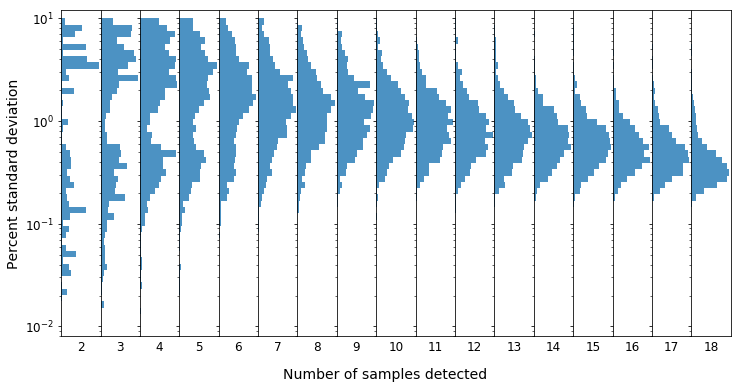

In [14]:
def survey_precision(fittingRes):
    surveyRes = [[[], []] for i in range(18)]
    for res in fittingRes:
        if len(res['stdevs'])>1:
            surveyRes[np.sum(res['config'])-1][0].append(res['stdevs'][2]/res['params'][2])
            surveyRes[np.sum(res['config'])-1][1].append(max(np.abs(res['params'][2] - res['ci95'][2][0]), np.abs(res['params'][2] - res['ci95'][2][1]))/res['params'][2])
    return surveyRes


def precision_plot(surveyRes):
    import matplotlib.pyplot as plt
    import plot
    
    lowest = 0.01
    highest = 10

    fig,ax = plt.subplots(1, 17, figsize=[12,6], sharey=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    bins = np.logspace(np.log10(lowest), np.log10(highest), 50)
    for i in range(17):
        res = surveyRes[i+1]
        ax[i].hist(res[0], bins=bins, alpha=0.8, density=False, orientation='horizontal')
        ax[i].set_yscale('log')
        ax[i].set_ylim([0.008, 12])
        plot.set_ticks_size(ax[i])
        ax[i].set_xticks([])
        ax[i].set_xlabel(str(i+2), fontsize=12)
    ax[0].set_ylabel('Percent standard deviation', fontsize=14)
    fig.text(s='Number of samples detected', x=0.5, y=0.02, ha='center', va='bottom', fontsize=14)
    
    fig.savefig('/home/yuning/Work/ribozyme_pred/fig/ci_est/bto_res_precision_pctstd_deep.png', dpi=300)
    plt.show()
    
surveyRes = survey_precision(fittingRes)
precision_plot(surveyRes)

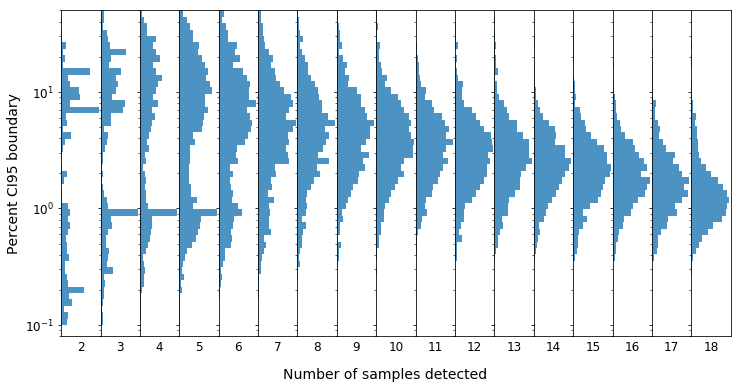

In [16]:
def survey_precision(fittingRes):
    surveyRes = [[[], []] for i in range(18)]
    for res in fittingRes:
        if len(res['stdevs'])>1:
            surveyRes[np.sum(res['config'])-1][0].append(res['stdevs'][2]/res['params'][2])
            surveyRes[np.sum(res['config'])-1][1].append(max(np.abs(res['params'][2] - res['ci95'][2][0]), np.abs(res['params'][2] - res['ci95'][2][2]))/res['params'][2])
    return surveyRes


def precision_plot(surveyRes):
    import matplotlib.pyplot as plt
    import plot
    
    lowest = 0.1
    highest = 50

    fig,ax = plt.subplots(1, 17, figsize=[12,6], sharey=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    bins = np.logspace(np.log10(lowest), np.log10(highest), 50)
    for i in range(17):
        res = surveyRes[i+1]
        ax[i].hist(res[1], bins=bins, alpha=0.8, density=False, orientation='horizontal')
        ax[i].set_yscale('log')
        ax[i].set_ylim([0.08, 50])
        plot.set_ticks_size(ax[i])
        ax[i].set_xticks([])
        ax[i].set_xlabel(str(i+2), fontsize=12)
    ax[0].set_ylabel('Percent CI95 boundary', fontsize=14)
    fig.text(s='Number of samples detected', x=0.5, y=0.02, ha='center', va='bottom', fontsize=14)
    
    # fig.savefig('/home/yuning/Work/ribozyme_pred/fig/ci_est/bto_res_precision_pctci95.png', dpi=300)
    plt.show()
    
surveyRes = survey_precision(fittingRes)
precision_plot(surveyRes)


In [ ]:
def survey_precision(fittingRes):
    surveyRes = [[res['params'][2] - 2*res['stdevs'][2], res['params'][2] + 2*res['stdevs'][2], res['ci95'][2][0], res['ci95'][2][1]] for res in fittingRes]
    for res in fittingRes:
        if len(res['stdevs'])>1 and np.sum(res['config'])>=12:
            
            surveyRes[np.sum(res['config'])-1][0].append(res['stdevs'][2]/res['params'][2])
            surveyRes[np.sum(res['config'])-1][1].append(max(np.abs(res['params'][2] - res['ci95'][2][0]), np.abs(res['params'][2] - res['ci95'][2][1]))/res['params'][2])
    return surveyRes

In [17]:
import numpy as np

surveyRes = np.array([[res['params'][2] - 2*res['stdevs'][2], res['params'][2] + 2*res['stdevs'][2], res['ci95'][2][0], res['ci95'][2][1]] for res in fittingRes if len(res['stdevs'])>1 and np.sum(res['config'])>=12]).T

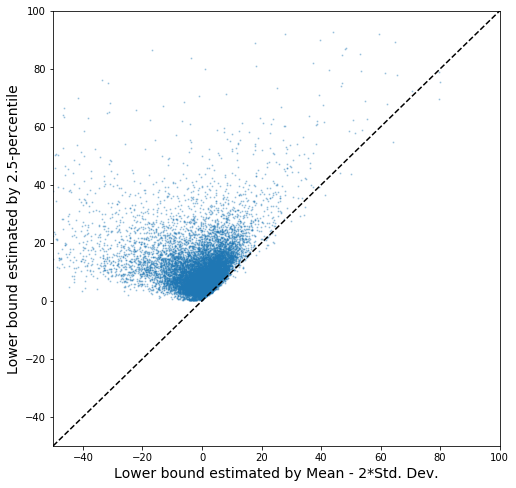

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=[8, 8])
plt.scatter(surveyRes[0], surveyRes[2], s=1, alpha=0.3)
plt.xlim([-50, 100])
plt.ylim([-50, 100])
plt.xlabel('Lower bound estimated by Mean - 2*Std. Dev.', fontsize=14)
plt.ylabel('Lower bound estimated by 2.5-percentile', fontsize=14)
plt.plot([-50, 100], [-50, 100], 'k--')
plt.show()

### Estimated value
Include all the ribozymes with number of samples detected larger than 6

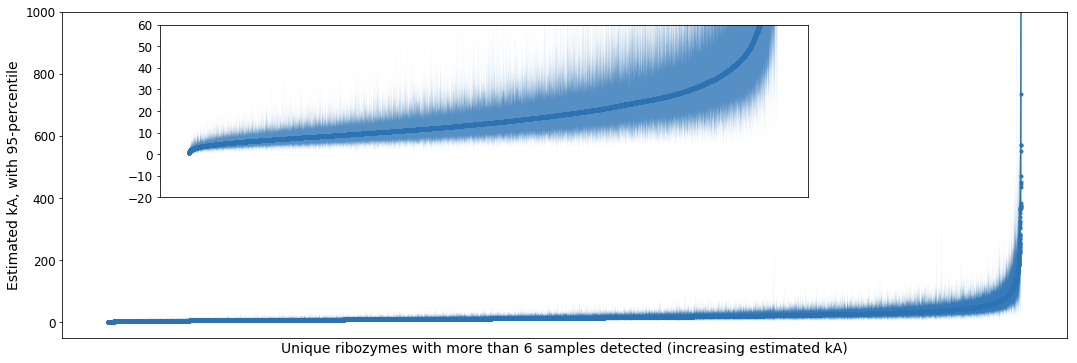

In [23]:
def filter_fn(res, percentile=True):
    if percentile:
        return [res['ci95'][2][3], res['ci95'][2][0], res['ci95'][2][2]]
    else:
        return [res['params'][2], res['params'][2]-2*res['stdevs'][2], res['params'][2]+2*res['stdevs'][2]]


def value_plot(surveyRes):
    import matplotlib.pyplot as plt
    import plot
    
    lowest = 0.01
    highest = 10
    
    fig = plt.figure(figsize=[18,6])
    ax = fig.add_subplot(111)
    ax.plot([i for i in range(len(surveyRes))], [res[0] for res in surveyRes], '.-', color='#2C73B4')
    ax.fill_between([i for i in range(len(surveyRes))],
                    y1=[res[1] for res in surveyRes],
                    y2=[res[2] for res in surveyRes],
                    alpha=0.95, facecolor='#2C73B4')
    plot.set_ticks_size(ax)
    ax.set_ylim([-50, 1000])
    ax.set_ylabel('Estimated kA, with 95-percentile', fontsize=14)
    ax.set_xticks([])
    ax.set_xlabel('Unique ribozymes with more than 6 samples detected (increasing estimated kA)', fontsize=14)
    axInset = fig.add_axes([0.2, 0.45, 0.5, 0.4])
    axInset.plot([i for i in range(len(surveyRes))], [res[0] for res in surveyRes], '.-', color='#2C73B4')
    axInset.fill_between([i for i in range(len(surveyRes))],
                    y1=[res[1] for res in surveyRes],
                    y2=[res[2] for res in surveyRes],
                    alpha=0.80, facecolor='#2C73B4')
    plot.set_ticks_size(axInset)
    axInset.set_ylim([-20, 60])
    axInset.set_xticks([])
    
    
    # ax.set_xlim([25600,25750])
    # fig.savefig('/home/yuning/Work/ribozyme_pred/fig/ci_est/bto_res_values_larg6_normality.png', dpi=300)
    plt.show()

surveyRes = []
for res in fittingRes:
    if np.sum(res['config']) > 6 and ~np.isnan(res['params'][2]):
        if ~np.isnan(res['ci95'][2][1]):
            surveyRes.append(filter_fn(res))
sort_fn = lambda a: (a[0])
surveyRes.sort(key=sort_fn)

value_plot(surveyRes)

In [36]:
len(surveyRes)

25715

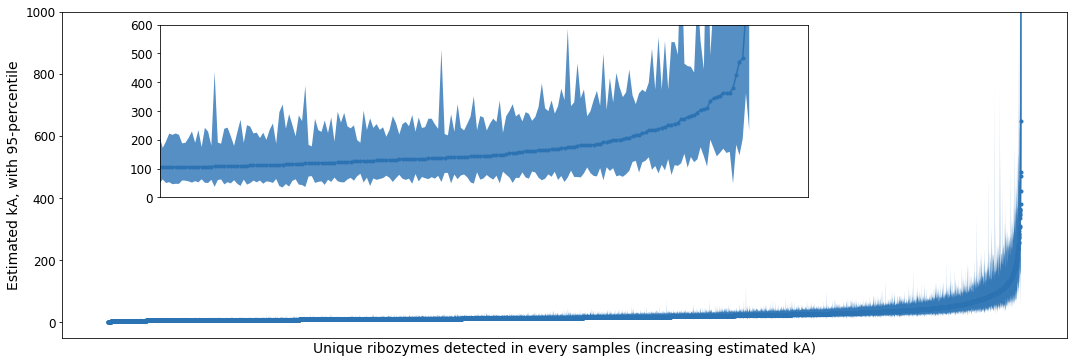

In [40]:
def filter_fn(res, percentile=True):
    if percentile:
        return [res['ci95'][2][1], res['ci95'][2][0], res['ci95'][2][2]]
    else:
        return [res['params'][2], res['params'][2]-2*res['stdevs'][2], res['params'][2]+2*res['stdevs'][2]]


def value_plot(surveyRes):
    import matplotlib.pyplot as plt
    import plot
    
    lowest = 0.01
    highest = 10
    
    fig = plt.figure(figsize=[18,6])
    ax = fig.add_subplot(111)
    ax.plot([i for i in range(len(surveyRes))], [res[0] for res in surveyRes], '.-', color='#2C73B4')
    ax.fill_between([i for i in range(len(surveyRes))],
                    y1=[res[1] for res in surveyRes],
                    y2=[res[2] for res in surveyRes],
                    alpha=0.95, facecolor='#2C73B4')
    plot.set_ticks_size(ax)
    ax.set_ylim([-50, 1000])
    ax.set_ylabel('Estimated kA, with 95-percentile', fontsize=14)
    ax.set_xticks([])
    ax.set_xlabel('Unique ribozymes detected in every samples (increasing estimated kA)', fontsize=14)
    axInset = fig.add_axes([0.2, 0.45, 0.5, 0.4])
    axInset.plot([i for i in range(len(surveyRes))], [res[0] for res in surveyRes], '.-', color='#2C73B4')
    axInset.fill_between([i for i in range(len(surveyRes))],
                    y1=[res[1] for res in surveyRes],
                    y2=[res[2] for res in surveyRes],
                    alpha=0.80, facecolor='#2C73B4')
    plot.set_ticks_size(axInset)
    axInset.set_xlim([8000, 8200])
    axInset.set_ylim([0, 600])
    axInset.set_xticks([])
    
    
    # ax.set_xlim([25600,25750])
    # fig.savefig('/home/yuning/Work/ribozyme_pred/fig/ci_est/bto_res_values_only18_normality.png', dpi=300)
    plt.show()

surveyRes = []
for res in fittingRes:
    if np.sum(res['config']) == 18 and ~np.isnan(res['params'][2]):
        if ~np.isnan(res['ci95'][2][1]):
            surveyRes.append(filter_fn(res))
sort_fn = lambda a: (a[0])
surveyRes.sort(key=sort_fn)

value_plot(surveyRes)

In [191]:
len(surveyRes)

25709

In [179]:
counter = 0
for res in fittingRes:
    if np.sum(res['config']) > 6 and len(res['stdevs'])>1 and np.isnan(res['params'][2]):
        print(res)
        counter += 1
    if counter == 10:
        break

#### Apply t-test to ribozymes
- Notice that t-test assume tha kA should be normally distributed in each population

In [199]:
def t_test(res1, res2):
    from scipy import stats
    t = (res1['params'][2] - res2['params'][2])/np.sqrt(res1['stdevs'][2]**2/500 + res2['stdevs'][2]**2/500)
    df = 2*500 - 2
    p = 1 - stats.t.cdf(t, df=df)
    return (t, p)

surveyRes = []
for res in fittingRes:
    if np.sum(res['config']) > 6 and ~np.isnan(res['params'][2]):
        if ~np.isnan(res['ci95'][2][1]):
            surveyRes.append(res)

for res1 in surveyRes[:1]:
    for res2 in surveyRes:
        t,p = t_test(res1, res2)

In [200]:
len(surveyRes)

25709

## Bootstrapping test

In [44]:
import numpy as np

def fitting(seq, xdata, maxFold=None, fitMtd='trf', ciEst=True, func=None, bsDepth=2000):
    """
    :param seq: the sequence to fit
    :param xdata: the x-value, corresponding to the list of ALL samples
    :param maxFold: if the maximum reacted fraction can exceed the indicated value, default None
    :param fitMtd: fitting method to use
    :param ciEst: If the confidence interval will be estimated by bootstrapping
    :param func: func to fit, if None will fit to default exponential function
    :return: seq with fitting results
    """
    from scipy.optimize import curve_fit
    import numpy as np

    def exp_func(x, A, k):
        return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BTO degradation adjustment and 90 minutes

    if func is None:
        func = exp_func
    ydata = np.array(seq['reactedFrac'][1:])
    if not(maxFold is None):
        ydata = np.array([min(yi, maxFold) for yi in ydata])
    valid = ~np.isnan(ydata)
    try:
        initGuess = [np.random.random(), np.random.random()]
        params, pcov = curve_fit(func, xdata=xdata[valid], ydata=ydata[valid],
                                 method=fitMtd, bounds=([0, 0], [1., np.inf]), p0=initGuess)
        x_ = xdata[valid]
        y_ = ydata[valid]
        yHat = func(x_, params[0], params[1])
        res = y_ - yHat
        pctRes = res / yHat
        ss_res = np.sum(res ** 2)
        ss_tot = np.sum((ydata[valid] - np.mean(ydata[valid])) ** 2)
        seq['r2'] = (1 - ss_res / ss_tot)
    except RuntimeError:
        params = [np.nan, np.nan]
    seq['params'] = [params[0], params[1], params[0]*params[1]]
    if ciEst:
        if (len(xdata[valid])>1)and(~np.isnan(params[0])):
            paramList = []
            for i in range(bsDepth):
                pctResResampled = np.random.choice(pctRes, replace=True, size=len(pctRes))
                yToFit = yHat + yHat * pctResResampled
                try:
                    initGuess = (np.random.random(), np.random.random())
                    params, pcov = curve_fit(func, x_, yToFit,
                                             method=fitMtd, bounds=([0, 0], [1., np.inf]), p0=initGuess)
                except:
                    params = [np.nan, np.nan]
                    print(x_, yToFit)
                paramList.append([params[0], params[1], params[0] * params[1]])
            seq['stdevs'] = np.nanstd(paramList, axis=0, ddof=1)
            seq['bsRes'] = paramList
            seq['ci95'] = np.array([np.nanpercentile(paramList, 2.5, axis=0), np.nanpercentile(paramList, 50, axis=0), np.nanpercentile(paramList, 97.5, axis=0), np.nanmean(paramList, axis=0)]).T
        else:
            seq['stdevs'] = [np.nan]
            seq['ci95'] = [np.nan]

    return seq

counter = [0, 0, 0, 0]
selectFitted = []
for seq in fittingRes:
    if 2 <= np.sum(seq['config']) <=5:
        if counter[np.sum(seq['config'])-2] < 5:
            selectFitted.append(fitting(seq, xdata=np.array([0.00025 for i in range(6)] +
                                                            [0.00005 for i in range(6)] +
                                                            [0.00001 for i in range(6)] +
                                                            [0.000002 for i in range(6)])))
            counter[np.sum(seq['config'])-2] += 1
    if np.sum(counter) == 20:
        break

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[2.5e-04 2.5e-04 2.5e-04 2.5e-04 2.0e-06] [0.009261   0.04860218 0.02560958 0.02560958 0.00108028]
[2.5e-04 2.5e-04 2.5e-04 2.5e-04 2.0e-06] [0.02560958 0.02560958 0.02560958 0.009261   0.00108028]
[2.5e-04 2.5e-04 2.5e-04 2.5e-04 2.0e-06] [0.05761101 0.02560958 0.13205531 0.05761101 0.00108028]
[2.5e-04 2.5e-04 2.5e-04 2.5e-04 2.0e-06] [0.05761101 0.009261   0.02560958 0.04860218 0.00108028]
[2.5e-04 2.5e-04 2.5e-04 2.5e-04 2.0e-06] [0.04860218 0.13205531 0.04860218 0.05761101 0.00108028]
[2.5e-04 2.5e-04 2.5e-04 2.5e-04 2.0e-06] [0.009261   0.009261   0.05761101 0.05761101 0.00108028]
[2.5e-04 2.5e-04 2.5e-04 2.5e-04 2.0e-06] [0.02560958 0.04860218 0.04860218 0.05761101 0.00108028]
[2.5e-04 2.5e-04 2.5e-04 2.5e-04 2.0e-06] [0.04860218 0.009261   0.02560958 0.02560958 0.00108028]
[2.5e-04 2.5e-04 2.5e-04 2.0e-06 2.0e-06] [0.0563674  0.0563674  0.02852475 0.00287625 0.00208023]
[2.5e-04 2.5e-04 2.5e-04 2.0e-06 2.0e-06] [0.02852475 0.03847463 0.02852475 0.00208023 0.00208023]
[2.5e-04 2

In [45]:
import util

util.dump_pickle(data=selectFitted,
                 dirc='/mnt/storage/projects/ribozyme_predict/k_seq/selectedBSRes_abe_sparse.pkl',
                 log='20 first ribozymes has 2~5 total number of samples in Abe\'s BYO selection, full record of booststrap 2000 results',
                 overwrite=False)

Data has been saved to /mnt/storage/projects/ribozyme_predict/k_seq/selectedBSRes_abe_sparse.pkl


In [212]:
selectFitted = util.load_pickle('/mnt/storage/projects/ribozyme_predict/k_seq/bsConvergenceTestRes.pkl')

bsConvergenceTestRes.pkl:
Bootstrapping convergence test results of selected Abe's data, the bootstrap is practice separately on 10, 20, ..., 2000 depth, on Pod (40 cores)


In [215]:
len(selectedFitted)

90

One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is not estimatable
One selected sample is no

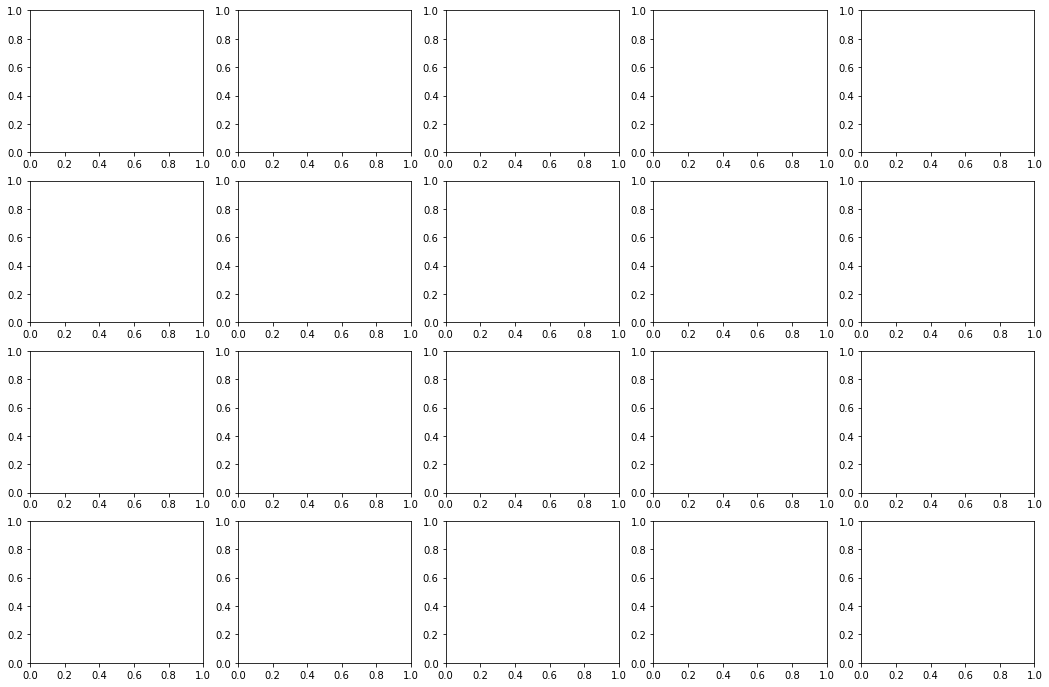

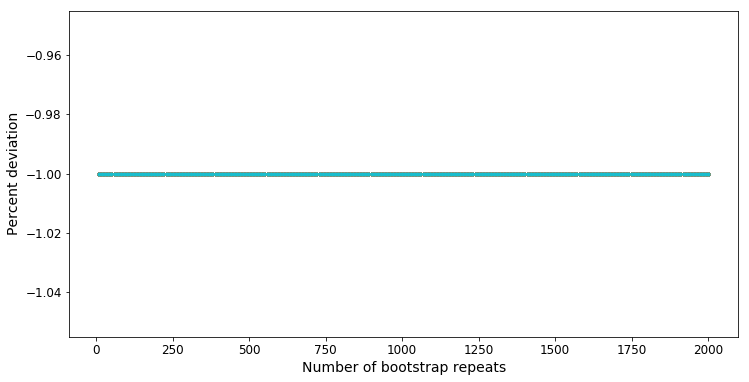

In [213]:
import matplotlib.pyplot as plt
import plot
bsSizes = [(i+1)*10 for i in range(200)]
for sample in selectFitted:
    try:
        kAList = np.array(sample['bsRes']).T[2]
        bsProfile = []
        for setSize in bsSizes:
            selected = np.random.choice(kAList, replace=True, size=setSize)
            bsProfile.append({
                'mean': np.nanmean(selected),
                'std': np.nanstd(selected, ddof=1),
                'pct2.5': np.nanpercentile(selected, 2.5),
                'pct97.5': np.nanpercentile(selected, 97.5),
                'pct50': np.nanpercentile(selected, 50)
            })
        sample['bsProfile'] = bsProfile
    except:
        sample['bsProfile'] = [{
            'mean': -1,
            'std': -1,
            'pct2.5': -1,
            'pct97.5': -1,
            'pct50': -1
        } for i in range(200)]
        print('One selected sample is not estimatable')
    

fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(111)
for sample in selectFitted:
    ax.plot(bsSizes, [bs['pct50'] for bs in sample['bsProfile']], '.-')
plot.set_ticks_size(ax)
ax.set_xlabel('Number of bootstrap repeats', fontsize=14)
ax.set_ylabel('Percent deviation', fontsize=14)
# fig.savefig('/home/yuning/Work/ribozyme_pred/fig/ci_est/simuSet_1_partial_method_5_bs_converge.png', dpi=300)
plt.show()

In [207]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(4,5, figsize=[18,12])
for ix in range(20):
    ax = axes[int(ix/5)][int(ix%5)]
    ax.hist([i[2] for i in selectFitted[ix]['bsRes']], bins=50)
    ax.set_yticks([])

plt.tight_layout()
plt.show()

NameError: name 'selectFitted' is not defined

## More serious bootstrap convergence test
### Select representative sequences
- Number of detected times 2, 4, 6, 8, 10, 12, 14, 16, 18
- 10 random CI-estimatable sequences for each detected times

In [1]:
import numpy as np
import util

fittingRes = util.load_pickle('/mnt/storage/projects/ribozyme_predict/k_seq/fittingRes_abe_deep.pkl')
seqCandid = [seq for seq in fittingRes if len(seq['stdevs'])>1]

fittingRes_abe_deep.pkl:
Fitting results of Abe's data, including the CI 95 estimation using 1000 bootstrap, on Pod (40 cores)


In [21]:
np.random.shuffle(seqCandid)
counter = [0 for i in range(9)]
selectedSeq = []

for seq in seqCandid:
    if 2 <= np.sum(seq['config']) <=18:
        if counter[int(np.sum(seq['config'])/2)-1] < 10:
            selectedSeq.append({
                'id': seq['id'],
                'config': seq['config'],
                'seq': seq['seq'],
                'rawCounts': seq['rawCounts'],
                'reactedFrac': seq['reactedFrac']
            })
            counter[int(np.sum(seq['config'])/2)-1] += 1

In [23]:
util.dump_pickle(data=selectedSeq,
                 dirc='/mnt/storage/projects/ribozyme_predict/k_seq/selectedSeq_abe.pkl',
                 log='Selected subsets of 90 ribozymes with CI estimatable, has number of detected times from 2, 4, 6, ..., 18. 10 ribozymes each',
                 overwrite=False)

Data has been saved to /mnt/storage/projects/ribozyme_predict/k_seq/selectedSeq_abe.pkl


In [216]:
convergeRes = util.load_pickle('/mnt/storage/projects/ribozyme_predict/k_seq/bsConvergenceTestRes.pkl')
len(convergeRes)
order_fn = lambda x: np.sum(x['config'])
convergeRes.sort(key=order_fn)

bsConvergenceTestRes.pkl:
Bootstrapping convergence test results of selected Abe's data, the bootstrap is practice separately on 10, 20, ..., 2000 depth, on Pod (40 cores)


In [147]:
def converge_profile(bsRes, statistic):
    statisticMap = {
        'pct2.5': 0,
        'pct50': 1,
        'pct97.5': 2,
        'mean': 3,
        'sd': 4
    }
    if statistic != 'psd':
        ix = statisticMap[statistic]
        return [[depth[ix][2] for depth in res['bsRes']] for res in bsRes]
    else:
        return [[depth[4][2]/depth[3][2] for depth in res['bsRes']] for res in bsRes]


def converge_plot(statistic, pctDev=False):
    import matplotlib.pyplot as plt
    import plot
    
    fig,axes = plt.subplots(3, 3, figsize=[12,10])
    bsDepthList = [i*10+10 for i in range(200)]
    if pctDev:
        for i in range(9):
            ax = axes[int(i/3), i%3]
            convergeProfile = converge_profile(convergeRes[10*i:10*i+10], statistic=statistic)
            for seq in convergeProfile:
                ax.plot(bsDepthList[10:],
                        [np.nanstd(seq[pos:pos+10], ddof=1)/np.nanmean(seq[pos:pos+10]) 
                         for pos in range(190)],
                        '.-', markersize=2, lw=0.5, alpha=0.5)
                ax.set_yscale('log')
                ax.set_ylim([10**-4, 1])
            ax.text(s='Sample Number: %s~' %(i*2+2), x=0.99*ax.get_xlim()[1], y=0.99*ax.get_ylim()[1], ha='right', va='top', fontsize=12)
        fig.text(s='Local percent deviation of statistics', x=0, y=0.5, ha='right', va='center', fontsize=16, rotation=90)
    else:
        for i in range(9):
            ax = axes[int(i/3), i%3]
            convergeProfile = converge_profile(convergeRes[10*i:10*i+10], statistic=statistic)
            for seq in convergeProfile:
                ax.plot(bsDepthList, seq, '.-', markersize=2, lw=0.5, alpha=0.5)
            ax.text(s='Sample Number: %s~' %(i*2+2), x=0.99*ax.get_xlim()[1], y=0.99*ax.get_ylim()[1], ha='right', va='top', fontsize=12)
        fig.text(s='Values of statistics', x=0, y=0.5, ha='right', va='center', fontsize=16, rotation=90)
    
    plot.set_ticks_size(ax)
    fig.text(s='Number of bootstrap samples', x=0.5, y=0, ha='center', va='top', fontsize=16)
    plt.tight_layout()
    # if pctDev:
    #     fig.savefig('/home/yuning/Work/ribozyme_pred/fig/BYO_results/bs_convergTest_%s_psd.png' %statistic, dpi=300, bbox_inches='tight')
    # else:
    #     fig.savefig('/home/yuning/Work/ribozyme_pred/fig/BYO_results/bs_convergTest_%s_val.png' %statistic, dpi=300, bbox_inches='tight')
    plt.show()


for statType in ['pct2.5', 'pct50', 'pct97.5', 'mean', 'sd', 'psd']:
    for plotType in [True, False]:
        converge_plot(statistic=statType, pctDev=plotType)

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


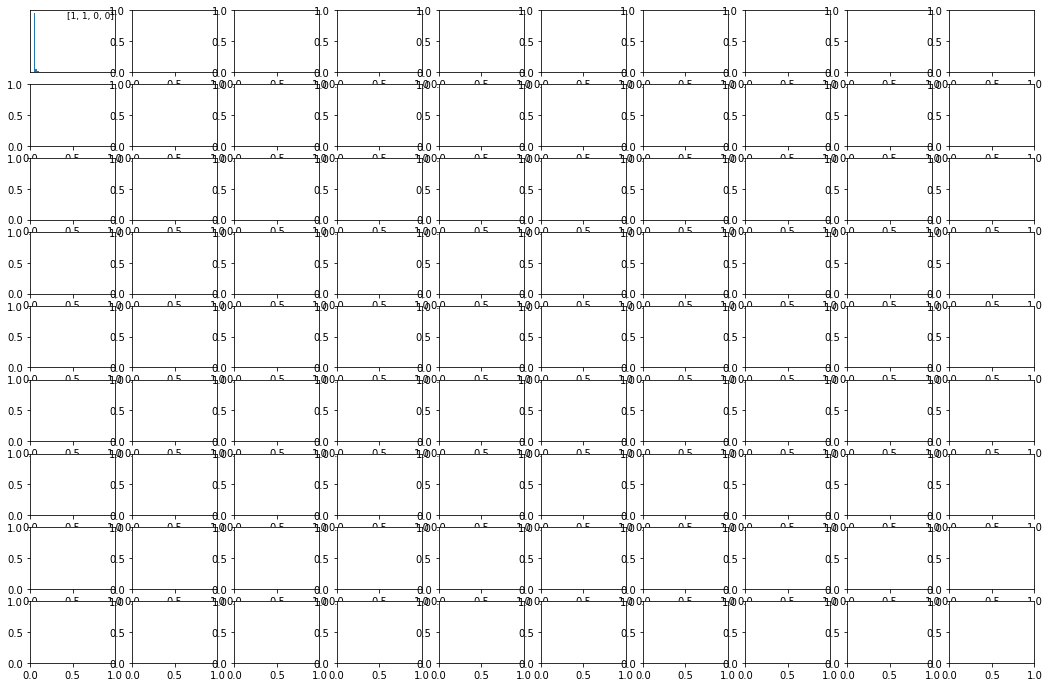

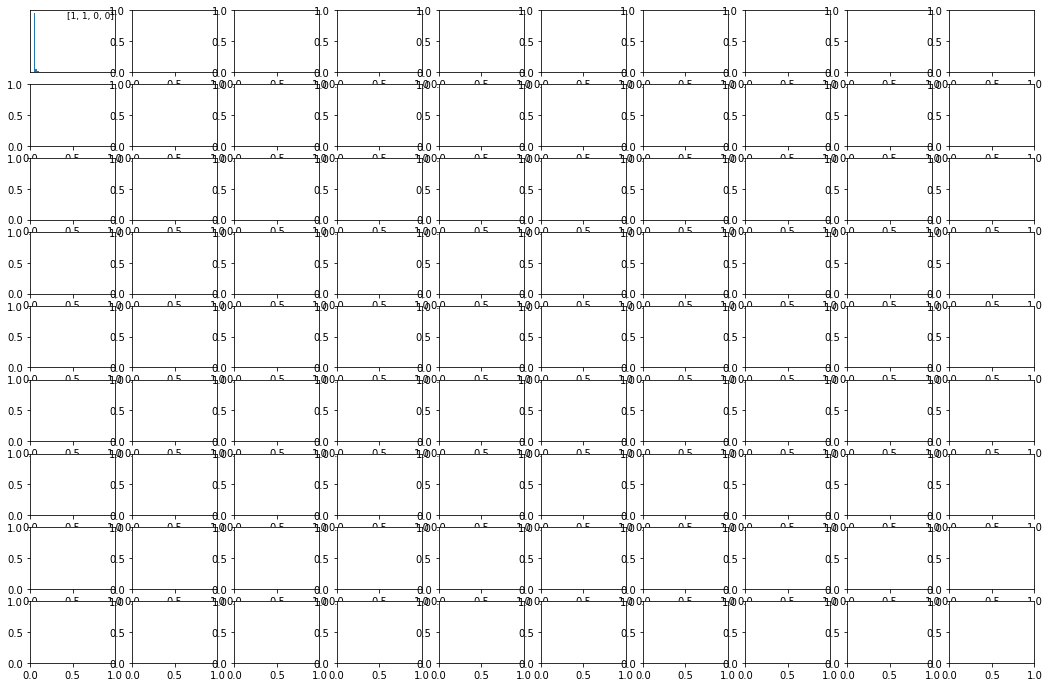

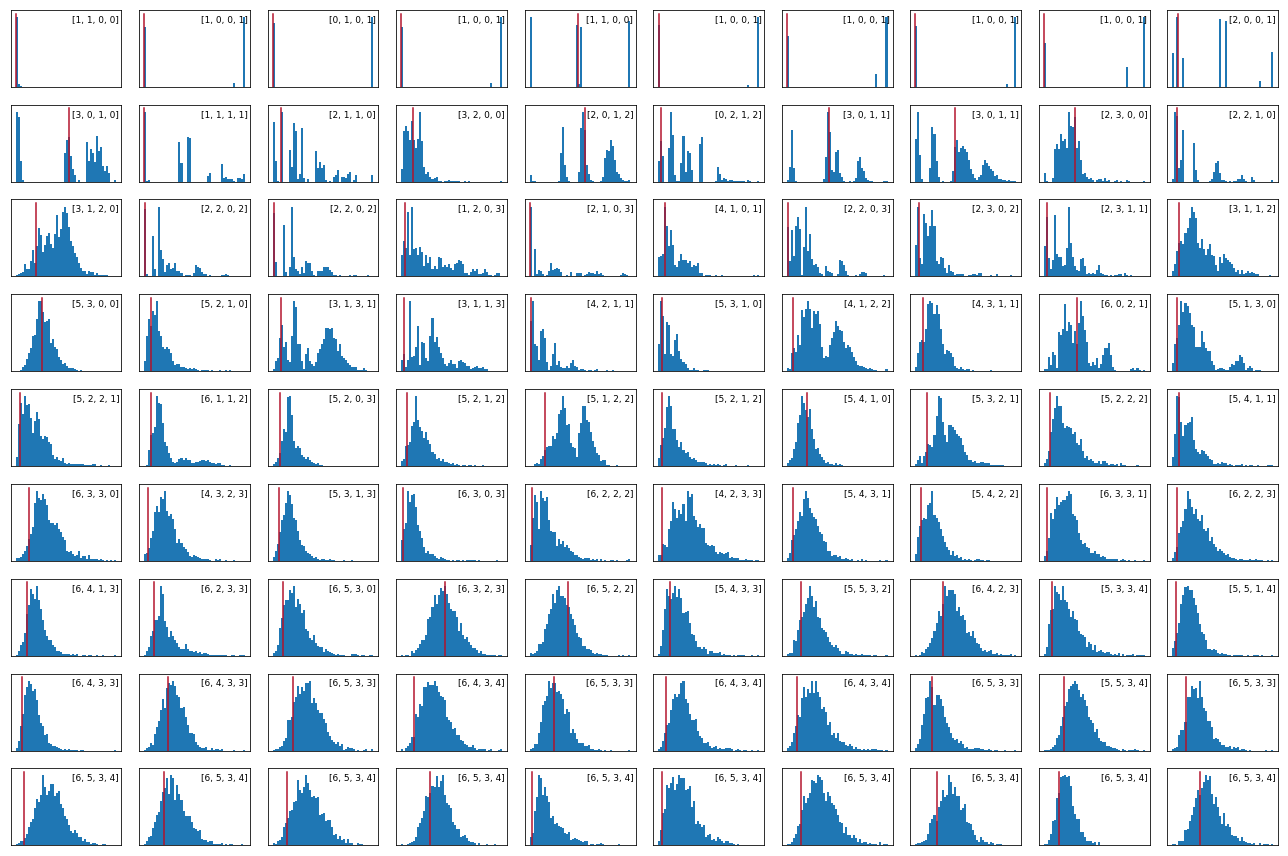

In [224]:
def distribution_plot():
    import matplotlib.pyplot as plt
    import plot
    
    fig,axes = plt.subplots(9, 10, figsize=[18,12])
    for i in range(90):
        ax = axes[int(i/10), i%10]
        paramList = np.array(convergeRes[i]['paramList']).T
        ax.hist(paramList[2], bins=50)
        ax.text(s='%s' %convergeRes[i]['config'], x=0.98*ax.get_xlim()[1]+0.02*ax.get_xlim()[0], y=0.98*ax.get_ylim()[1], ha='right', va='top', fontsize=9)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.plot([convergeRes[i]['params'][2], convergeRes[i]['params'][2]], [0, ax.get_ylim()[1]], color='#B2112A')
    
    plt.tight_layout()
    # fig.savefig('/home/yuning/Work/ribozyme_pred/fig/BYO_results/bs_convergTest_bsSampleDist.png', dpi=300, bbox_inches='tight')
    plt.show()

distribution_plot()

In [221]:
convergeRes[0].keys()

dict_keys(['id', 'config', 'seq', 'rawCounts', 'reactedFrac', 'r2', 'params', 'bsRes', 'paramList'])

In [65]:
import pandas as pd

df = pd.read_csv('/mnt/storage/projects/ribozyme_predict/k_seq/fittingResSelected.csv')

In [66]:
df

,name,seq,inputCount,config,kAEstimate,CIEstimate,k,A,kA,kSD,...,kA97.5,kAMean,k2.5,k50,k97.5,kMean,A2.5,A50,A97.5,AMean
0,S-2.1-a,ATTACCCTGGTCATCGAGTGA,84277,[6 5 3 4],1,1,124.431199,0.254453,31.661943,210.301183,...,217.256410,100.383561,44.179808,143.882828,849.569269,220.078577,0.183688,0.629729,1.0,0.657354
1,S-2.1-b,ATTACCCTGGTCATCGAGTGT,372,[6 5 3 4],1,1,113.441036,0.263043,29.839818,187.172139,...,194.043007,94.499096,43.360119,123.396648,761.599644,193.326684,0.192062,0.702603,1.0,0.694276
2,S-1B.1-a,CCACACTTCAAGCAATCGGTC,9884,[6 5 3 4],1,1,44.980560,1.000000,44.980560,61.773218,...,80.934344,54.759934,37.795912,65.038078,266.392114,90.289546,0.269188,0.925973,1.0,0.760733
3,S-1B.2-a,CCGCTTCAAGCAATCGGTCGC,14829,[6 5 3 4],1,1,33.718477,1.000000,33.718477,61.180051,...,60.007254,41.824196,27.878551,48.178391,234.901613,74.371953,0.223217,0.999958,1.0,0.753469
4,S-1B.3-a,CCGAGTTTCAAGCAATCGGTC,7954,[6 5 3 4],1,1,30.525306,1.000000,30.525306,59.848089,...,62.625465,41.072561,27.228042,47.630731,249.816281,73.437383,0.207643,0.999992,1.0,0.759837
5,S-1A.1-a,CTACTTCAAACAATCGGTCTG,79838,[6 5 3 4],1,1,25.128470,1.000000,25.128470,60.611449,...,59.600338,40.198254,26.001728,46.104002,253.683705,70.850910,0.197867,0.999997,1.0,0.771671
6,S-2.2-a,ATTCACCTAGGTCATCGGGTG,3175,[6 5 3 4],1,1,13.492166,0.999999,13.492159,63.199593,...,41.608375,26.465963,17.372693,30.588480,256.527813,61.298797,0.127591,0.999976,1.0,0.715956
7,S-1A.4-a,CTCTTCAAACAATCGGTCTTC,4388,[6 5 3 4],1,1,16.188915,1.000000,16.188915,68.125493,...,37.573411,23.676779,15.216551,29.663015,253.418888,65.202642,0.119292,0.997726,1.0,0.665329
8,S-3.1-a,AAGTTTGCTAATAGTCGCAAG,7894,[6 5 3 4],1,1,12.039172,1.000000,12.039172,64.254551,...,31.943953,20.530803,13.257894,25.762528,238.749999,59.293042,0.104810,0.999313,1.0,0.663717
9,S-1C.1-a,CTCTTCAATAATCGGTTGCGT,3597,[6 5 3 4],1,1,7.718380,1.000000,7.718380,62.049432,...,14.104684,9.526252,6.433646,11.579385,217.103712,46.371162,0.055513,0.979001,1.0,0.613944


# Compare to Abe's results
## repeat Abe's code to recover results

In [139]:
import pandas as pd
import numpy as np

def read_csv(dirc):
    data = pd.read_csv(dirc)
    uniqueCounts = data.get_value(0, 'Abun R5c-counts.txt')
    totalCounts = data.get_value(1, 'Abun R5c-counts.txt')
    samples = data[2:]
    samples.loc[:, 'kL_avg'] = samples.loc[:, 'L by avg'] * samples.loc[:, 'k by avg']
    samples.loc[:,'seq_length'] = samples['X'].str.len()
    return samples, uniqueCounts, totalCounts

resAbe, uniAbe, totAbe = read_csv('/mnt/storage/projects/ribozyme_predict/archived_analysis_on_abe_data/archive/abe_raw_data/allseqs-name-fit.csv') # fitting results from Abe
resRep, uniRep, totRep = read_csv('/mnt/storage/projects/ribozyme_predict/k_seq/abe_all_seqs-name-fit.csv') # fitting results from me repeating Abe's experiments

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Compare my repeated results to Abe's fitting results


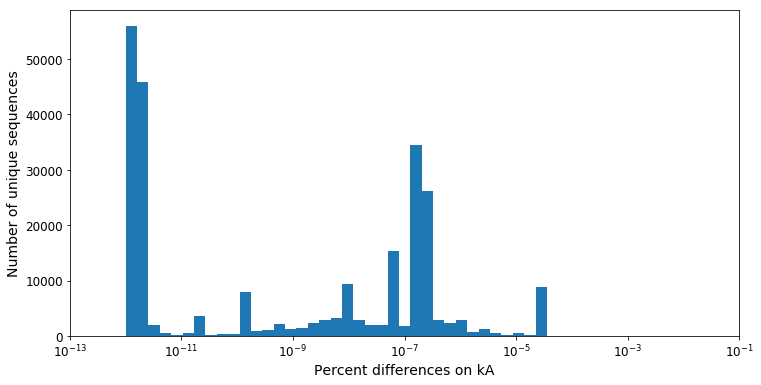

In [140]:
print(util.color.BOLD + util.color.BLUE + \
'Compare my repeated results to Abe\'s fitting results'+ util.color.END)

import plot
diff = abs(resJoined['rep_kA'] - resJoined['kL_avg'])/resJoined['kL_avg']
fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(111)
bins = np.logspace(-12, -2, 50)
ax.hist(diff, bins=bins)
ax.set_xlim([10**-13, 10**-1])
ax.set_xscale('log')
ax.set_xlabel('Percent differences on kA', fontsize=14)
ax.set_ylabel('Number of unique sequences', fontsize=14)
plot.set_ticks_size(ax)
plt.show()

In [81]:
len(validSeq[0][1])

25

### Exports data

In [ ]:
def export_csv(fittingRes, dirc):
    fittingRes.sort(key=sort_fn, reverse=True)
    with open(dirc, 'w') as output:
        output.write('name,seq,inputCount,config,kAEstimate,CIEstimate,k,A,kA,kSD,ASD,kASD,kA2.5,kA50,kA97.5,kAMean,k2.5,k50,k97.5,kMean,A2.5,A50,A97.5,AMean\n')
        for res in fittingRes:
            output.write('%s,%s,%i,%s,' %(res['name'], res['seq'], res['rawCounts'][0], np.array(res['config'])))
            output.write('1,1,%f,%f,%f,%f,%f,%f,%s\n' %(res['params'][1], res['params'][0], res['params'][2],
                                                        res['stdevs'][1], res['stdevs'][0], res['stdevs'][2],
                                                    ','.join(['%f'%i for i in list(res['ci95'][2]) + list(res['ci95'][1]) + list(res['ci95'][0])])))

export_csv(selectedRes, dirc='/mnt/storage/projects/ribozyme_predict/k_seq/fittingResSelected.csv')

In [35]:
def sort_fn(res):
    if np.isnan(res['params'][2]):
        return (0, 0)
    elif len(res['ci95'])==1:
        return (1, 0)
    else:
        return (1, res['ci95'][2][1])

def export_csv(fittingRes, dirc):
    fittingRes.sort(key=sort_fn, reverse=True)
    with open(dirc, 'w') as output:
        output.write('seq,inputCount,config,kAEstimate,CIEstimate,k,A,kA,kSD,ASD,kASD,kA2.5,kA50,kA97.5,kAMean,k2.5,k50,k97.5,kMean,A2.5,A50,A97.5,AMean\n')
        for res in fittingRes:
            output.write('%s,%i,%s,' %(res['seq'], res['rawCounts'][0], np.array(res['config'])))
            if np.isnan(res['params'][2]):
                output.write('0,0,%s\n' %(','.join(['nan' for i in range(18)])))
            elif len(res['ci95'])==1:
                output.write('1,0,%f,%f,%f,%s\n' %(res['params'][1], res['params'][0], res['params'][2],
                                                            ','.join(['nan' for i in range(12)])))
            else:
                output.write('1,1,%f,%f,%f,%f,%f,%f,%s\n' %(res['params'][1], res['params'][0], res['params'][2],
                                                            res['stdevs'][1], res['stdevs'][0], res['stdevs'][2],
                                                    ','.join(['%f'%i for i in list(res['ci95'][2]) + list(res['ci95'][1]) + list(res['ci95'][0])])))

export_csv(fittingRes, dirc='/mnt/storage/projects/ribozyme_predict/k_seq/fittingRes_deep.csv')

## Import results from both pipelines

In [100]:
import util

fittingResAbe = util.load_pickle('/mnt/storage/projects/ribozyme_predict/k_seq/abe_fittingRes.pkl')
fittingRes = util.load_pickle('/mnt/storage/projects/ribozyme_predict/k_seq/repeat_res/fittingRes_byo_edit_2_repeated.pkl')
fittingResOnAbeData = util.load_pickle('/mnt/storage/projects/ribozyme_predict/k_seq/repeat_res/fittingRes_byo_abeData_fix.pkl')
fittingRes = {res['seq']:res for res in fittingRes}
fittingResAbe = {res['seq']:res for res in fittingResAbe}
fittingResOnAbeData = {res['seq']:res for res in fittingResOnAbeData}

abe_fittingRes.pkl:
Fitting results from Abe's code
fittingRes_byo_edit_2_repeated.pkl:
Fitting results of BYO data, including the CI 95 estimation using 1000 bootstrap, on Pod (40 cores) the reacted fraction is calculated based on qFactor with edit distance 2
fittingRes_byo_abeData_fix.pkl:
Fitting results of BYO data with qFactor from Abe, including the CI 95 estimation using 1000 bootstrap, on Pod (40 cores), UPDATE: invalid samples runs are excluded


Data structure:
- fittingRes (results from my estimation):
  - 'seq'
  - 'rawCounts'
  - 'config'
  - 'id'
  - 'reactedFrac': n=25 np.array
  - 'r2'
  - 'params': k, A, k\*A estimated from all valid data points
  - 'stdevs': standard deviations of k, A, kA, (ddof=1)
  - 'ci95': 3\*4 np.array (pct-2.5, pct-50, pct-97.5, mean) for k, A, kA in the bootstrapped sample
- fittingResAbe (results from Abe's code, my repetition)
  - 'seq
  - 'normedAmount': normalized amount of seqs in 25 samples, ng
  - 'params': k, A, kA estimated
  - 'stddev': standard deviation of k, A, kA in three replicates, ddof=0
  - 'stddevSeries': original k, A, kA estimated in three replicates
  - 'stddevYValue': original y values of three replicates
  - 'yValue': averaged yValue used for fitting to estimate k, A, kA

## Test on selected 10 sequences 

In [112]:
selectedSeq = [
    ('S-2.1-a', 'ATTACCCTGGTCATCGAGTGA'),
    ('S-2.1-b', 'ATTACCCTGGTCATCGAGTGT'),
    ('S-1A.1-a', 'CTACTTCAAACAATCGGTCTG'),
    ('S-1B.1-a', 'CCACACTTCAAGCAATCGGTC'),
    ('S-1B.2-a', 'CCGCTTCAAGCAATCGGTCGC'),
    ('S-1B.3-a', 'CCGAGTTTCAAGCAATCGGTC'),
    ('S-3.1-a', 'AAGTTTGCTAATAGTCGCAAG'),
    ('S-2.2-a', 'ATTCACCTAGGTCATCGGGTG'),
    ('S-1A.4-a', 'CTCTTCAAACAATCGGTCTTC'),
    ('S-1C.1-a', 'CTCTTCAATAATCGGTTGCGT')
]

for ix in [0, 1, 2]:
    print('Comparison estimated param %i' %ix)
    for seq in selectedSeq:
        print('%s, %s, %f, %f, %f, %f, %f, %f' %(
            seq[0],
            seq[1],
            fittingResAbe[seq[1]]['params'][ix]/40.11,
            fittingResAbe[seq[1]]['stddev'][ix]/40.11,
            fittingResOnAbeData[seq[1]]['params'][ix],
            fittingResOnAbeData[seq[1]]['stdevs'][ix],
            fittingResOnAbeData[seq[1]]['ci95'][ix][0],
            fittingResOnAbeData[seq[1]]['ci95'][ix][2]
        ))

Comparison estimated param 0
S-2.1-a, ATTACCCTGGTCATCGAGTGA, 0.004005, 0.000168, 0.160389, 0.019793, 0.154108, 0.230283
S-2.1-b, ATTACCCTGGTCATCGAGTGT, 0.003948, 0.000172, 0.158228, 0.022803, 0.151070, 0.235632
S-1A.1-a, CTACTTCAAACAATCGGTCTG, 0.007051, 0.001718, 0.290476, 0.175262, 0.225752, 0.999966
S-1B.1-a, CCACACTTCAAGCAATCGGTC, 0.021553, 0.004621, 0.963209, 0.202251, 0.396601, 1.000000
S-1B.2-a, CCGCTTCAAGCAATCGGTCGC, 0.016683, 0.006849, 0.733550, 0.252610, 0.311292, 1.000000
S-1B.3-a, CCGAGTTTCAAGCAATCGGTC, 0.011407, 0.007797, 0.485486, 0.263309, 0.273552, 1.000000
S-3.1-a, AAGTTTGCTAATAGTCGCAAG, 0.003345, 0.000314, 0.137471, 0.096329, 0.112013, 0.439214
S-2.2-a, ATTCACCTAGGTCATCGGGTG, 0.003293, 0.000469, 0.133768, 0.042602, 0.115109, 0.269149
S-1A.4-a, CTCTTCAAACAATCGGTCTTC, 0.006263, 0.003626, 0.268555, 0.314997, 0.158609, 1.000000
S-1C.1-a, CTCTTCAATAATCGGTTGCGT, 0.024931, 0.000000, 0.999964, 0.389472, 0.091175, 1.000000
Comparison estimated param 1
S-2.1-a, ATTACCCTGGTCATCGA

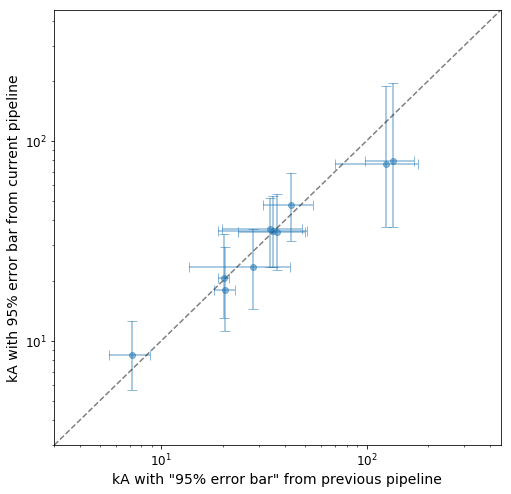

In [50]:
import plot
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(111)
predAbe = [fittingResAbe[seq[1]]['params'][2]/40.11 for seq in selectedSeq]
predAbe95 = [(2*fittingResAbe[seq[1]]['stddev'][2]/40.11, 2*fittingResAbe[seq[1]]['stddev'][2]/40.11) for seq in selectedSeq]
pred = [fittingRes[seq[1]]['ci95'][2][1] for seq in selectedSeq]
pred95 = [(fittingRes[seq[1]]['ci95'][2][1] - fittingRes[seq[1]]['ci95'][2][0], fittingRes[seq[1]]['ci95'][2][2] - fittingRes[seq[1]]['ci95'][2][1]) for seq in selectedSeq]
ax.errorbar(x=predAbe, y=pred, xerr=np.array(predAbe95).T, yerr=np.array(pred95).T, marker='o', linestyle='', capsize=5, alpha=0.5)
plot.set_ticks_size(ax)
ax.plot([0, 450], [0, 450], 'k--', alpha=0.5)
ax.set_ylim([3, 450])
ax.set_xlim([3, 450])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('kA with "95% error bar" from previous pipeline', fontsize=14)
ax.set_ylabel('kA with 95% error bar from current pipeline', fontsize=14)

plt.show()

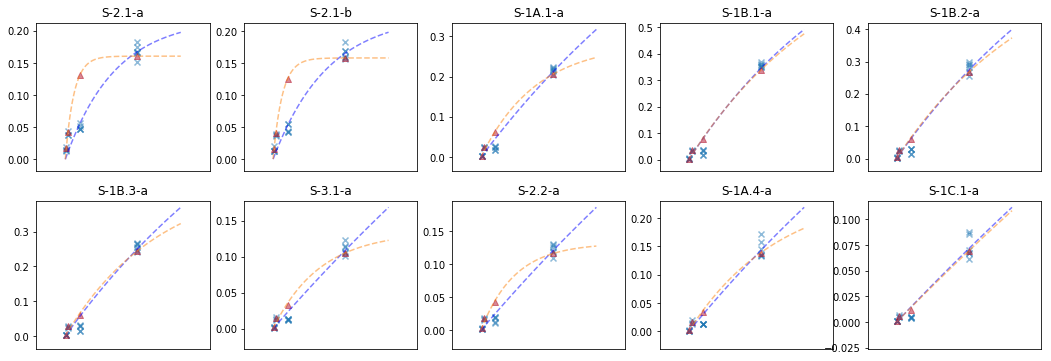

In [12]:
import matplotlib.pyplot as plt

def exp_func(x, A, k):
    return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BTO degradation adjustment and 90 minutes

xdata = np.array([0.00025 for i in range(6)] + 
                 [0.00005 for i in range(6)] +
                 [0.00001 for i in range(6)] +
                 [0.000002 for i in range(6)])

fig,axes = plt.subplots(2, 5, figsize=[18,6])

for ix,seq in enumerate(selectedSeq):
    ax = axes[int(ix/5), ix%5]
    ax.set_title(seq[0])
    ax.set_xticks([])
    ax.scatter(xdata, fittingRes[seq[1]]['reactedFrac'][1:], marker='x', alpha=0.5)
    x = np.arange(0, 0.00040, 0.0004/100)
    ax.plot(x, exp_func(x, fittingRes[seq[1]]['params'][0], fittingRes[seq[1]]['params'][1]), 'b--', alpha=0.5)
    ax.set_xlim([-0.0001, 0.0005])
    

xdata = np.array([0.00025, 0.00005, 0.00001, 0.000002])

for ix,seq in enumerate(selectedSeq):
    ax = axes[int(ix/5), ix%5]
    ax.scatter(xdata, fittingResAbe[seq[1]]['yValue'], marker='^', color='#B2112A', alpha=0.5)
    x = np.arange(0, 0.00040, 0.0004/100)
    ax.plot(x, exp_func(x, fittingResAbe[seq[1]]['params'][0], fittingResAbe[seq[1]]['params'][1]/43.11), color='#FC820D', linestyle='--', alpha=0.5)
    ax.set_xlim([-0.0001, 0.0005])
    
plt.show()

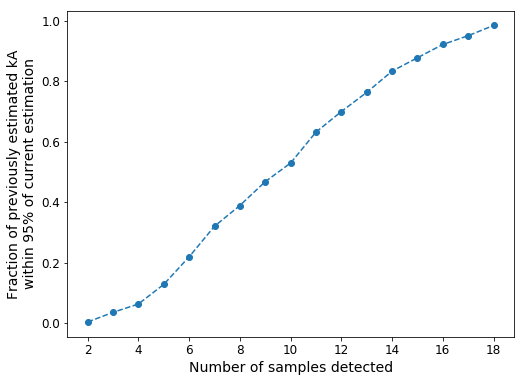

In [44]:
import numpy as np

def survey_ci95(fittingRes, fittingResAbe):
    counter = [[] for i in range(24)]
    for seq in fittingRes.values():
        dataNum = np.sum(seq['config'])
        if len(seq['ci95'])==3:
            if seq['seq'] in fittingResAbe.keys():
                counter[dataNum].append(seq['ci95'][2][0] <= fittingResAbe[seq['seq']]['params'][2]/40.11 <= seq['ci95'][2][2])
    return counter

def plot(counter):
    import matplotlib.pyplot as plt
    import plot
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax.plot(np.linspace(2, 18, 17), [np.mean(i) for i in counter[2:19]], 'o--')
    plot.set_ticks_size(ax)
    ax.set_ylabel('Fraction of previously estimated kA\nwithin 95% of current estimation', fontsize=14)
    ax.set_xlabel('Number of samples detected', fontsize=14)
    plt.show()
# counter = survey_ci95(fittingRes, fittingResAbe)
plot(counter)

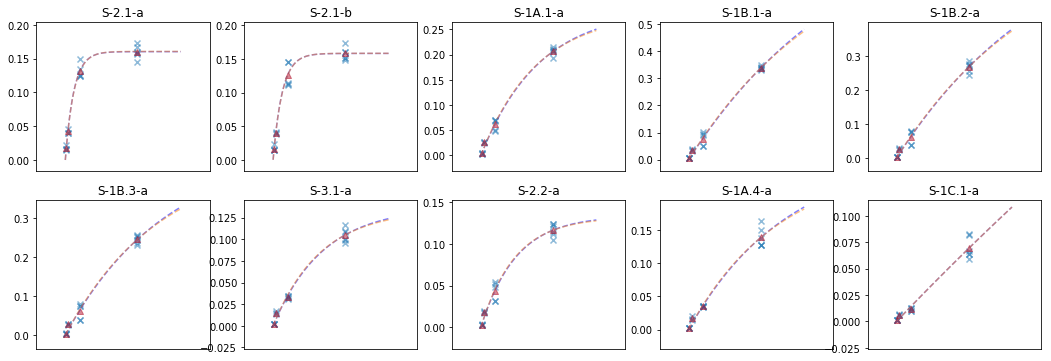

In [102]:
import matplotlib.pyplot as plt

def exp_func(x, A, k):
    return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BTO degradation adjustment and 90 minutes

xdata = np.array([0.00025 for i in range(6)] + 
                 [0.00005 for i in range(6)] +
                 [0.00001 for i in range(6)] +
                 [0.000002 for i in range(6)])

fig,axes = plt.subplots(2, 5, figsize=[18,6])

for ix,seq in enumerate(selectedSeq):
    ax = axes[int(ix/5), ix%5]
    ax.set_title(seq[0])
    ax.set_xticks([])
    ax.scatter(xdata, fittingResOnAbeData[seq[1]]['reactedFrac'][1:], marker='x', alpha=0.5)
    x = np.arange(0, 0.00040, 0.0004/100)
    ax.plot(x, exp_func(x, fittingResOnAbeData[seq[1]]['params'][0], fittingResOnAbeData[seq[1]]['params'][1]), 'b--', alpha=0.5)
    ax.set_xlim([-0.0001, 0.0005])
    
xdata = np.array([0.00025, 0.00005, 0.00001, 0.000002])

for ix,seq in enumerate(selectedSeq):
    ax = axes[int(ix/5), ix%5]
    ax.scatter(xdata, fittingResAbe[seq[1]]['yValue'], marker='^', color='#B2112A', alpha=0.5)
    x = np.arange(0, 0.00040, 0.0004/100)
    ax.plot(x, exp_func(x, fittingResAbe[seq[1]]['params'][0], fittingResAbe[seq[1]]['params'][1]/43.11), color='#FC820D', linestyle='--', alpha=0.5)
    ax.set_xlim([-0.0001, 0.0005])
    
plt.show()

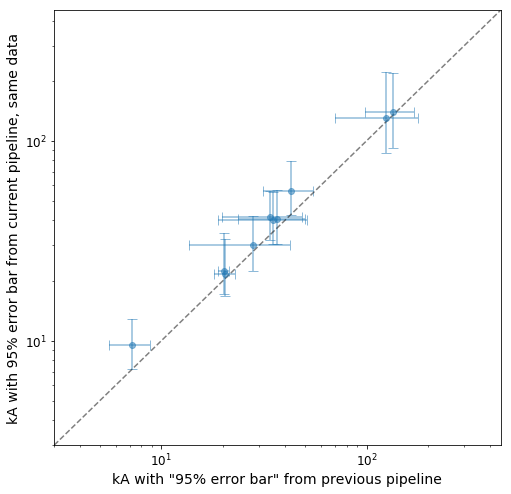

In [103]:
import plot
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(111)
predAbe = [fittingResAbe[seq[1]]['params'][2]/40.11 for seq in selectedSeq]
predAbe95 = [(2*fittingResAbe[seq[1]]['stddev'][2]/40.11, 2*fittingResAbe[seq[1]]['stddev'][2]/40.11) for seq in selectedSeq]
pred = [fittingResOnAbeData[seq[1]]['ci95'][2][1] for seq in selectedSeq]
pred95 = [(fittingResOnAbeData[seq[1]]['ci95'][2][1] - fittingResOnAbeData[seq[1]]['ci95'][2][0], fittingResOnAbeData[seq[1]]['ci95'][2][2] - fittingResOnAbeData[seq[1]]['ci95'][2][1]) for seq in selectedSeq]
ax.errorbar(x=predAbe, y=pred, xerr=np.array(predAbe95).T, yerr=np.array(pred95).T, marker='o', linestyle='', capsize=5, alpha=0.5)
plot.set_ticks_size(ax)
ax.plot([0, 450], [0, 450], 'k--', alpha=0.5)
ax.set_ylim([3, 450])
ax.set_xlim([3, 450])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('kA with "95% error bar" from previous pipeline', fontsize=14)
ax.set_ylabel('kA with 95% error bar from current pipeline, same data', fontsize=14)

plt.show()

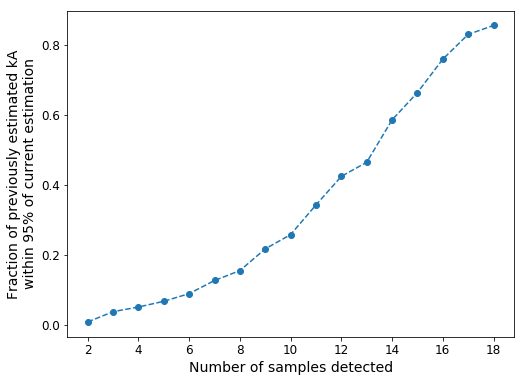

In [104]:
import numpy as np

def survey_ci95(fittingRes, fittingResAbe):
    counter = [[] for i in range(24)]
    
    validRnds = [
        1, 2, 3, 4, 5, 6,
        7, 8, 10, 11, 12,
        13, 14, 15,
        19, 20, 21, 23
    ]
    
    for seq in fittingRes.values():
        dataNum = np.sum([~np.isnan(seq['reactedFrac'][rnd]) for rnd in validRnds])
        if len(seq['ci95'])==3:
            if seq['seq'] in fittingResAbe.keys():
                counter[dataNum].append(seq['ci95'][2][0] <= fittingResAbe[seq['seq']]['params'][2]/40.11 <= seq['ci95'][2][2])
    return counter

def plot(counter):
    import matplotlib.pyplot as plt
    import plot
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax.plot(np.linspace(2, 18, 17), [np.mean(i) for i in counter[2:19]], 'o--')
    plot.set_ticks_size(ax)
    ax.set_ylabel('Fraction of previously estimated kA\nwithin 95% of current estimation', fontsize=14)
    ax.set_xlabel('Number of samples detected', fontsize=14)
    plt.show()
counter = survey_ci95(fittingResOnAbeData, fittingResAbe)
plot(counter)

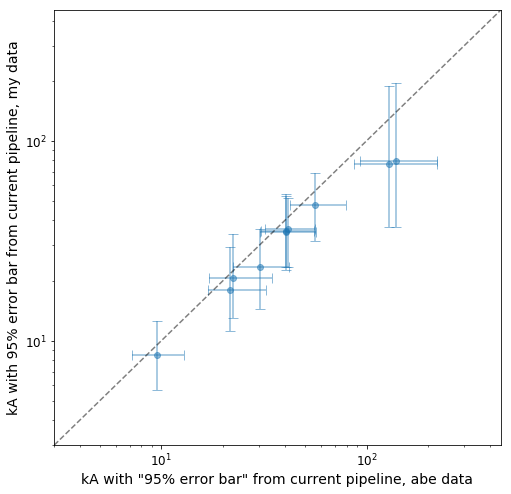

In [111]:
import plot
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(111)
pred = [fittingRes[seq[1]]['ci95'][2][1] for seq in selectedSeq]
pred95 = [(fittingRes[seq[1]]['ci95'][2][1] - fittingRes[seq[1]]['ci95'][2][0], fittingRes[seq[1]]['ci95'][2][2] - fittingRes[seq[1]]['ci95'][2][1]) for seq in selectedSeq]
predAbe = [fittingResOnAbeData[seq[1]]['ci95'][2][1] for seq in selectedSeq]
predAbe95 = [(fittingResOnAbeData[seq[1]]['ci95'][2][1] - fittingResOnAbeData[seq[1]]['ci95'][2][0], fittingResOnAbeData[seq[1]]['ci95'][2][2] - fittingResOnAbeData[seq[1]]['ci95'][2][1]) for seq in selectedSeq]
ax.errorbar(x=predAbe, y=pred, xerr=np.array(predAbe95).T, yerr=np.array(pred95).T, marker='o', linestyle='', capsize=5, alpha=0.5)
plot.set_ticks_size(ax)
ax.plot([0, 450], [0, 450], 'k--', alpha=0.5)
ax.set_ylim([3, 450])
ax.set_xlim([3, 450])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('kA with "95% error bar" from current pipeline, abe data', fontsize=14)
ax.set_ylabel('kA with 95% error bar from current pipeline, my data', fontsize=14)

plt.show()

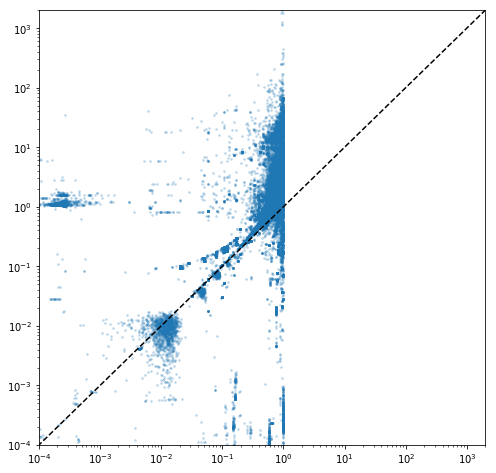

In [71]:
def survey_ci95_size(fittingRes, fittingResOnAbeData):
    sizes = [[], []]
    for seq in fittingRes.values():
        if len(seq['ci95'])==3 and len(fittingResOnAbeData[seq['seq']]['ci95'])==3:
            sizes[0].append((seq['ci95'][2][2] - seq['ci95'][2][0])/seq['ci95'][2][2])
            sizes[1].append((fittingResOnAbeData[seq['seq']]['ci95'][2][2] - fittingResOnAbeData[seq['seq']]['ci95'][2][0])/fittingResOnAbeData[seq['seq']]['ci95'][2][1])
    return sizes

# sizes = survey_ci95_size(fittingRes, fittingResOnAbeData)

fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(111)
ax.scatter(sizes[0], sizes[1], s=3, alpha=0.2)
ax.plot([0, 2000], [0, 2000], 'k--')
ax.set_ylim([0.0001, 2000])
ax.set_xlim([0.0001, 2000])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

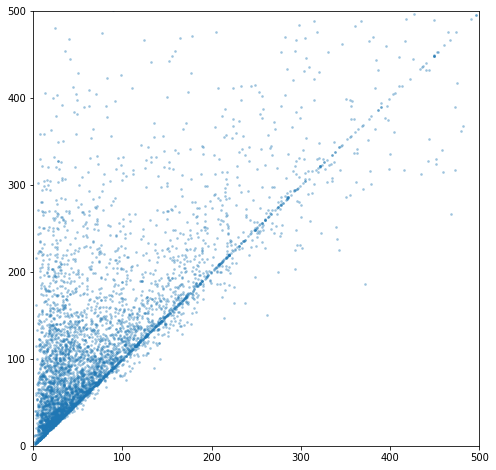

In [239]:
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111)
ax.scatter([seq['params'][2] for seq in fittingResBFOEstimatable], [seq['ci95'][2][3] for seq in fittingResBFOEstimatable], alpha=0.3, s=3)
ax.set_xlim([0, 500])
ax.set_ylim([0, 500])
plt.show()

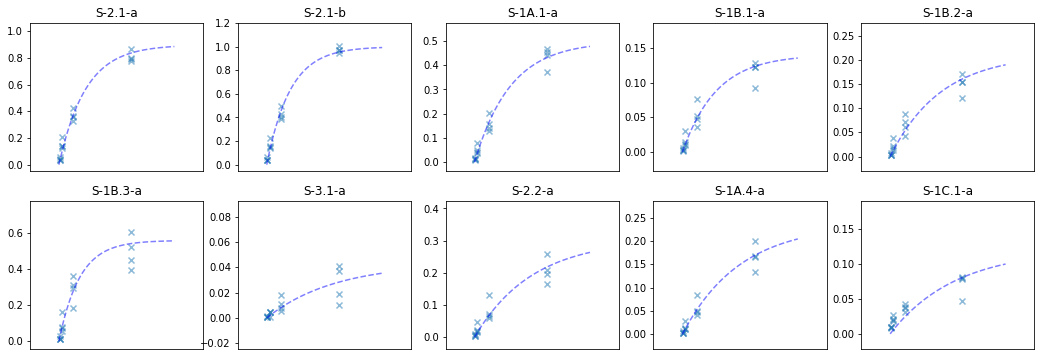

In [244]:
import matplotlib.pyplot as plt

def exp_func(x, A, k):
    return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BTO degradation adjustment and 90 minutes

xdata = np.array([0.001, 0.00025, 0.00005, 0.00001, 0.000002] +
                 [0.001, 0.00025, 0.00005, 0.00001, 0.000002] +
                 [0.001, 0.00025, 0.00005, 0.00001, 0.000002] +
                 [0.001, 0.00025, 0.00005, 0.00001, 0.000002])

fig,axes = plt.subplots(2, 5, figsize=[18,6])

for ix,seq in enumerate(selectedSeq):
    ax = axes[int(ix/5), ix%5]
    ax.set_title(seq[0])
    ax.set_xticks([])
    ax.scatter(xdata, fittingResBFO[seq[1]]['reactedFrac'], marker='x', alpha=0.5)
    x = np.arange(0, 0.00040, 0.0004/100)
    ax.plot(x, exp_func(x, fittingResBFO[seq[1]]['params'][0], fittingResBFO[seq[1]]['params'][1]), 'b--', alpha=0.5)
    ax.set_xlim([-0.0001, 0.0005])

plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('/mnt/storage/projects/ribozyme_predict/archived_analysis_on_abe_data/archive/abe_raw_data/allseqs-name-fit.csv')
unique_counts = data.get_value(0, 'Abun R5c-counts.txt')
total_counts = data.get_value(1, 'Abun R5c-counts.txt')
samples = data[2:]
samples.loc[:, 'kL_avg'] = samples.loc[:, 'L by avg'] * samples.loc[:, 'k by avg']
samples.loc[:,'seq_length'] = samples['X'].str.len()

In [47]:
selectedRes[0]

{'ci95': array([[1.83688490e-01, 6.29728725e-01, 1.00000000e+00, 6.57354104e-01],
        [4.41798084e+01, 1.43882828e+02, 8.49569269e+02, 2.20078577e+02],
        [3.81147800e+01, 8.97967194e+01, 2.17256410e+02, 1.00383561e+02]]),
 'config': [6, 5, 3, 4],
 'id': 133656,
 'name': 'S-2.1-a',
 'params': [0.2544534094107698, 124.43119929570508, 31.66194289786314],
 'r2': 0.9501610055052914,
 'rawCounts': [84277,
  559110,
  842063,
  411496,
  170055,
  304763,
  169927,
  708989,
  897139,
  nan,
  399950,
  410460,
  503086,
  416183,
  357863,
  396927,
  nan,
  nan,
  nan,
  903927,
  539963,
  593553,
  nan,
  398836,
  nan],
 'reactedFrac': array([1.        , 0.16989891, 0.18506469, 0.18753001, 0.19613997,
        0.20383615, 0.18684565, 0.05541124, 0.06103677,        nan,
        0.05069679, 0.05182825, 0.0510036 , 0.04807124, 0.04263065,
        0.04260859,        nan,        nan,        nan, 0.0218093 ,
        0.01384277, 0.0152132 ,        nan, 0.0151611 ,        nan]),
 'seq':

## Compare my repeated results with Abe's results

In [43]:
np.max(diff)

0.0010183506414063676

# Test code to repeat results from Abe's data

In [99]:
import util
import time
import multiprocessing as mp
import numpy as np

def fitting(seq, xdata, maxFold=None, fitMtd='trf', ciEst=True, func=None, bsDepth=1000):
    """
    :param seq: the sequence to fit
    :param xdata: the x-value, corresponding to the list of ALL samples
    :param maxFold: if the maximum reacted fraction can exceed the indicated value, default None
    :param fitMtd: fitting method to use
    :param ciEst: If the confidence interval will be estimated by bootstrapping
    :param func: func to fit, if None will fit to default exponential function
    :return: seq with fitting results
    """
    from scipy.optimize import curve_fit
    import numpy as np

    def exp_func(x, A, k):
        return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BYO degradation adjustment and 90 minutes

    if func is None:
        func = exp_func
    ydata = np.array(seq['reactedFrac'][1:])
    if not(maxFold is None):
        ydata = np.array([min(yi, maxFold) for yi in ydata])
    valid = ~np.isnan(ydata)
    try:
        initGuess = [np.random.random(), np.random.random()]
        params, pcov = curve_fit(func, xdata=xdata[valid], ydata=ydata[valid],
                                 method=fitMtd, bounds=([0, 0], [1., np.inf]), p0=initGuess)
        x_ = xdata[valid]
        y_ = ydata[valid]
        yHat = func(x_, params[0], params[1])
        res = y_ - yHat
        pctRes = res / yHat
        ss_res = np.sum(res ** 2)
        ss_tot = np.sum((ydata[valid] - np.mean(ydata[valid])) ** 2)
        seq['r2'] = (1 - ss_res / ss_tot)
    except RuntimeError:
        params = [np.nan, np.nan]
    except ValueError:
        global errorTrack
        errorTrack.append(seq)
        params = [np.nan, np.nan]
        print(seq)
    seq['params'] = [params[0], params[1], params[0]*params[1]]
    if ciEst:
        if (len(xdata[valid])>1)and(~np.isnan(params[0])):
            paramList = []
            for i in range(bsDepth):
                pctResResampled = np.random.choice(pctRes, replace=True, size=len(pctRes))
                yToFit = yHat + yHat * pctResResampled
                try:
                    initGuess = (np.random.random(), np.random.random())
                    params, pcov = curve_fit(func, x_, yToFit,
                                             method=fitMtd, bounds=([0, 0], [1., np.inf]), p0=initGuess)
                except:
                    params = [np.nan, np.nan]
                    print(x_, yToFit)
                paramList.append([params[0], params[1], params[0] * params[1]])
            seq['stdevs'] = np.nanstd(paramList, axis=0, ddof=1)
            seq['ci95'] = np.array([np.nanpercentile(paramList, 2.5, axis=0), np.nanpercentile(paramList, 50, axis=0),
                                    np.nanpercentile(paramList, 97.5, axis=0), np.nanmean(paramList, axis=0)]).T
        else:
            seq['stdevs'] = [np.nan]
            seq['ci95'] = [np.nan]

    return seq

def work_fn(seq):
    xdata = np.array([0.00025 for i in range(6)] +
                     [0.00005 for i in range(6)] +
                     [0.00001 for i in range(6)] +
                     [0.000002 for i in range(6)])
    validRnd = [0,
        1, 2, 3, 4, 5, 6,
        7, 8, 10, 11, 12,
        13, 14, 15,
        19, 20, 21, 23
    ]
    seq = {
        'seq': seq[0],
        'ng': seq[1],
        'reactedFrac': np.array([seq[1][i]/seq[1][0] if (seq[1][i]>0)and(i in validRnd) else np.nan for i in range(25)])
    }
    seq = fitting(seq, xdata, fitMtd='trf', ciEst=False)
    return seq

def main():
    timeInit = time.time()
    seqToFit = util.load_pickle('/mnt/storage/projects/ribozyme_predict/k_seq/abe_validSeqs.pkl')
    # seqToFit = seqToFit[:10]
    print(len(seqToFit))
    pool = mp.Pool(processes=7)
    seqToFit = pool.map(work_fn, seqToFit)
    timeEnd = time.time()
    print('Process finished in %i s' % (timeEnd - timeInit))

if __name__ == '__main__':
    errorTrack = []
    main()


abe_validSeqs.pkl:
The 403901 valid sequences (being detected at least once in valid k-seq samples) generated from Abe's code, (417265 seqs filtered by previous abe_validSeqs.pkl for unvalid samples). A list of sequences with [seq, [normalized counts in each samples, starting from input]]
403901


/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in double_scalars
/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in double_scalars
/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipyk

KeyboardInterrupt: 

  File "/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap


limit_output extension: Maximum message size of 10000 exceeded with 10018 characters

In [82]:
seqToFit = util.load_pickle('/mnt/storage/projects/ribozyme_predict/k_seq/abe_validSeqs.pkl')

abe_validSeqs.pkl:
The valid sequences (being detected at least once in valid k-seq samples) generated from                          Abe's code. A list of sequences with [seq, [normalized counts                           in each samples, starting from input]]


In [87]:
np.random.choice(seqToFit, size=10, replace=False)

ValueError: setting an array element with a sequence

# [Need to clean and substitude to above] Results on new pipeline on Abe's q factor

In [ ]:
import util
import numpy as np

def add_config(seq):
    validSampleList = [
        [1, 2, 3, 4, 5, 6],
        [7, 8, 10, 11, 12],
        [13, 14, 15],
        [19, 20, 21, 23]
    ]
    return [sum([1 for rep in repSet if ~np.isnan(seq['reactedFrac'][rep])]) for repSet in validSampleList]

def load_fittingRes(dirc):
    fittingRes = util.load_pickle(dirc)
    for seq in fittingRes:
        seq['config'] = add_config(seq)
    return fittingRes

fittingResNew = load_fittingRes('/mnt/storage/projects/ribozyme_predict/k_seq/repeat_res/fittingRes_byo_abeData_fix.pkl')

In [6]:
def res_survey(fittingRes):
    def filter_fn1(res):
        if len(res['stdevs']) == 1:
            return False
        elif 0.01 <= res['stdevs'][2]/res['params'][2] <=10:
            return True
        else:
            return False
    
    def filter_fn2_1(res):
        if len(res['stdevs']) == 1:
            return False
        elif res['ci95'][2][0]>=0.5*res['params'][2] and res['ci95'][2][1]<=1.5*res['params'][2]:
            return True
        else:
            return False
        
    def filter_fn2_2(res):
        if len(res['stdevs']) == 1:
            return False
        elif res['ci95'][2][0]>=0.5*res['ci95'][2][3] and res['ci95'][2][1]<=1.5*res['ci95'][2][3]:
            return True
        else:
            return False
    
    def filter_fn3(res):
        if len(res['stdevs']) == 1:
            return False
        elif res['ci95'][2][0]>=0.9*res['params'][2] and res['ci95'][2][1]<=1.1*res['params'][2]:
            return True
        else:
            return False
    
    print('Total unique ribozymes: %i' %len(fittingRes))
    print('Ribozymes can estimate mean: %i' %np.sum([1 for res in fittingRes if ~np.isnan(res['params'][2])]))
    print('Ribozymes can perform bootstrapping for CI estimation: %i' %np.sum([1 for res in fittingRes if len(res['stdevs'])>1]))
    print('Ribozymes has pct std in [0.01, 10] from std estimation: %i' %np.sum([1 for res in fittingRes if filter_fn1(res)]))
    print('Ribozymes has p2.5 >= 0.5 Mean and p97.5<=1.5 Mean: %i' %np.sum([1 for res in fittingRes if filter_fn2_1(res)]))
    print('Ribozymes has p2.5 >= 0.5 Bootstrapped Mean and p97.5<=1.5 Bootstrapped Mean: %i' %np.sum([1 for res in fittingRes if filter_fn2_2(res)]))
    print('Ribozymes has p2.5 >= 0.9 Mean and p97.5<=1.1 Mean: %i' %np.sum([1 for res in fittingRes if filter_fn3(res)]))
    print('Ribozymes with >=6 samples detected: %i' %np.sum([1 for res in fittingRes if np.sum(res['config'])>=6]))
    
res_survey(fittingResNew)

Total unique ribozymes: 403901
Ribozymes can estimate mean: 403636
Ribozymes can perform bootstrapping for CI estimation: 93943
Ribozymes has pct std in [0.01, 10] from std estimation: 84067
Ribozymes has p2.5 >= 0.5 Mean and p97.5<=1.5 Mean: 51207
Ribozymes has p2.5 >= 0.5 Bootstrapped Mean and p97.5<=1.5 Bootstrapped Mean: 45956
Ribozymes has p2.5 >= 0.9 Mean and p97.5<=1.1 Mean: 20699
Ribozymes with >=6 samples detected: 28132


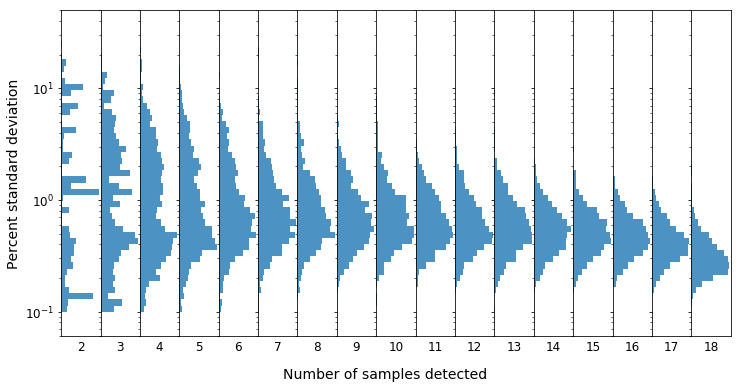

In [8]:
def survey_precision(fittingRes):
    surveyRes = [[[], []] for i in range(18)]
    for res in fittingRes:
        if len(res['stdevs'])>1:
            surveyRes[np.sum(res['config'])-1][0].append(res['stdevs'][2]/res['params'][2])
            surveyRes[np.sum(res['config'])-1][1].append(max(np.abs(res['params'][2] - res['ci95'][2][0]), np.abs(res['params'][2] - res['ci95'][2][2]))/res['params'][2])
    return surveyRes

def precision_plot(surveyRes):
    import matplotlib.pyplot as plt
    import plot
    
    lowest = 0.1
    highest = 50

    fig,ax = plt.subplots(1, 17, figsize=[12,6], sharey=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    bins = np.logspace(np.log10(lowest), np.log10(highest), 50)
    for i in range(17):
        res = surveyRes[i+1]
        ax[i].hist(res[0], bins=bins, alpha=0.8, density=False, orientation='horizontal')
        ax[i].set_yscale('log')
        ax[i].set_ylim([0.06, 50])
        plot.set_ticks_size(ax[i])
        ax[i].set_xticks([])
        ax[i].set_xlabel(str(i+2), fontsize=12)
    ax[0].set_ylabel('Percent standard deviation', fontsize=14)
    fig.text(s='Number of samples detected', x=0.5, y=0.02, ha='center', va='bottom', fontsize=14)
    
    # fig.savefig('/home/yuning/Work/ribozyme_pred/fig/ci_est/bto_res_precision_pctci95.png', dpi=300)
    plt.show()
    
surveyRes = survey_precision(fittingResNew)
precision_plot(surveyRes)

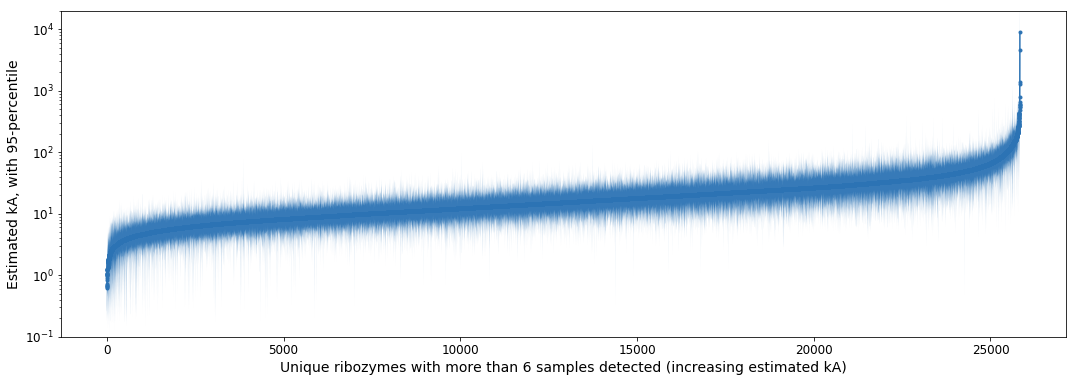

In [214]:
def filter_fn(res, percentile=True):
    if percentile:
        return [res['ci95'][2][3], res['ci95'][2][0], res['ci95'][2][2]]
    else:
        return [res['params'][2], res['params'][2]-2*res['stdevs'][2], res['params'][2]+2*res['stdevs'][2]]


def value_plot(surveyRes):
    import matplotlib.pyplot as plt
    import plot
    
    lowest = 0.01
    highest = 10
    
    fig = plt.figure(figsize=[18,6])
    ax = fig.add_subplot(111)
    ax.plot([i for i in range(len(surveyRes))], [res[0] for res in surveyRes], '.-', color='#2C73B4')
    ax.fill_between([i for i in range(len(surveyRes))],
                    y1=[res[1] for res in surveyRes],
                    y2=[res[2] for res in surveyRes],
                    alpha=0.95, facecolor='#2C73B4')
    plot.set_ticks_size(ax)
    ax.set_yscale('log')
    ax.set_ylim([0.1, 20000])
    ax.set_ylabel('Estimated kA, with 95-percentile', fontsize=14)
    ax.set_xlabel('Unique ribozymes with more than 6 samples detected (increasing estimated kA)', fontsize=14)
    # axInset = fig.add_axes([0.2, 0.45, 0.5, 0.4])
    # axInset.plot([i for i in range(len(surveyRes))], [res[0] for res in surveyRes], '.-', color='#2C73B4')
    # axInset.fill_between([i for i in range(len(surveyRes))],
    #                 y1=[res[1] for res in surveyRes],
    #                 y2=[res[2] for res in surveyRes],
    #                 alpha=0.80, facecolor='#2C73B4')
    # plot.set_ticks_size(axInset)
    # axInset.set_ylim([0.1, 10000])
    # axInset.set_yscale('log')
    # axInset.set_xticks([])
    
    
    # ax.set_xlim([25600,25750])
    # fig.savefig('/home/yuning/Work/ribozyme_pred/fig/ci_est/bto_res_values_larg6_normality.png', dpi=300)
    plt.show()

    
def kA_sorted_curve(fittingRes):
    surveyRes = []
    for res in fittingRes:
        if np.sum(res['config']) > 6 and ~np.isnan(res['params'][2]):
            if ~np.isnan(res['ci95'][2][1]):
                surveyRes.append(filter_fn(res))
    sort_fn = lambda a: (a[0])
    surveyRes.sort(key=sort_fn)
    value_plot(surveyRes)

kA_sorted_curve(fittingResNew)

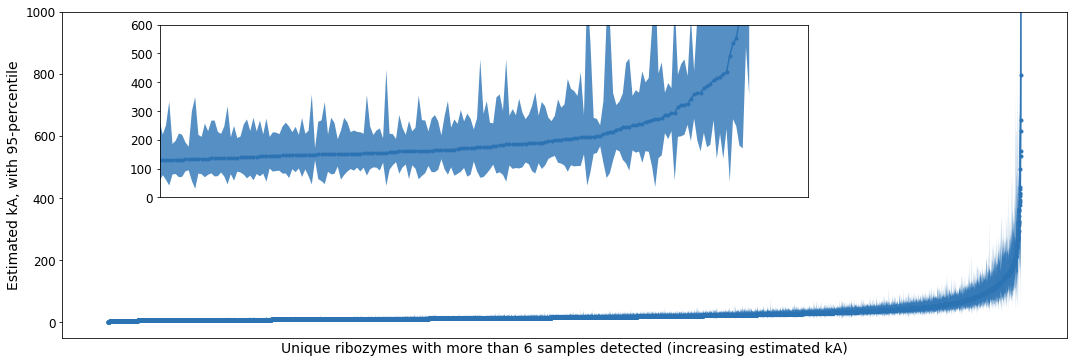

In [132]:
def filter_fn(res, percentile=True):
    if percentile:
        return [res['ci95'][2][3], res['ci95'][2][0], res['ci95'][2][2]]
    else:
        return [res['params'][2], res['params'][2]-2*res['stdevs'][2], res['params'][2]+2*res['stdevs'][2]]


def value_plot(surveyRes):
    import matplotlib.pyplot as plt
    import plot
    
    lowest = 0.01
    highest = 10
    
    fig = plt.figure(figsize=[18,6])
    ax = fig.add_subplot(111)
    ax.plot([i for i in range(len(surveyRes))], [res[0] for res in surveyRes], '.-', color='#2C73B4')
    ax.fill_between([i for i in range(len(surveyRes))],
                    y1=[res[1] for res in surveyRes],
                    y2=[res[2] for res in surveyRes],
                    alpha=0.95, facecolor='#2C73B4')
    plot.set_ticks_size(ax)
    ax.set_ylim([-50, 1000])
    ax.set_ylabel('Estimated kA, with 95-percentile', fontsize=14)
    ax.set_xticks([])
    ax.set_xlabel('Unique ribozymes with more than 6 samples detected (increasing estimated kA)', fontsize=14)
    axInset = fig.add_axes([0.2, 0.45, 0.5, 0.4])
    axInset.plot([i for i in range(len(surveyRes))], [res[0] for res in surveyRes], '.-', color='#2C73B4')
    axInset.fill_between([i for i in range(len(surveyRes))],
                    y1=[res[1] for res in surveyRes],
                    y2=[res[2] for res in surveyRes],
                    alpha=0.80, facecolor='#2C73B4')
    plot.set_ticks_size(axInset)
    axInset.set_xlim([8000, 8200])
    axInset.set_ylim([0, 600])
    axInset.set_xticks([])
    
    
    # ax.set_xlim([25600,25750])
    # fig.savefig('/home/yuning/Work/ribozyme_pred/fig/ci_est/bto_res_values_larg6_normality.png', dpi=300)
    plt.show()

    
def kA_sorted_curve(fittingRes):
    surveyRes = []
    for res in fittingRes:
        if np.sum(res['config']) == 18 and ~np.isnan(res['params'][2]):
            if ~np.isnan(res['ci95'][2][1]):
                surveyRes.append(filter_fn(res))
    sort_fn = lambda a: (a[0])
    surveyRes.sort(key=sort_fn)
    value_plot(surveyRes)

kA_sorted_curve(fittingResNew)

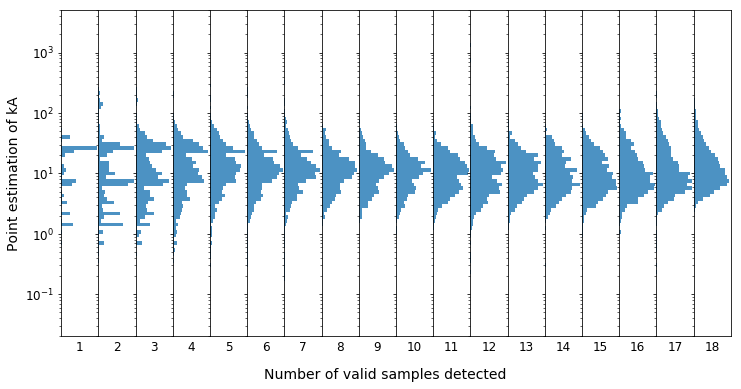

In [203]:
def survey_kA(fittingRes):
    surveyRes = [[] for i in range(19)]
    for res in fittingRes:
        surveyRes[np.sum(res['config'])].append(res['params'][2])
    return surveyRes

def precision_plot(surveyRes):
    import matplotlib.pyplot as plt
    import plot
    
    lowest = 0.01
    highest = 10000

    fig,ax = plt.subplots(1, 18, figsize=[12,6], sharey=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    bins = np.logspace(np.log10(lowest), np.log10(highest), 100)
    for i in range(18):
        res = surveyRes[i+1]
        ax[i].hist(res, bins=bins, alpha=0.8, density=False, orientation='horizontal')
        ax[i].set_yscale('log')
        ax[i].set_ylim([0.02, 5000])
        plot.set_ticks_size(ax[i])
        ax[i].set_xticks([])
        ax[i].set_xlabel(str(i+1), fontsize=12)
    ax[0].set_ylabel('Point estimation of kA', fontsize=14)
    fig.text(s='Number of valid samples detected', x=0.5, y=0.02, ha='center', va='bottom', fontsize=14)
    
    # fig.savefig('/home/yuning/Work/ribozyme_pred/fig/ci_est/bto_res_precision_pctci95.png', dpi=300)
    plt.show()
    
surveyRes = survey_kA(fittingResNew)
precision_plot(surveyRes)

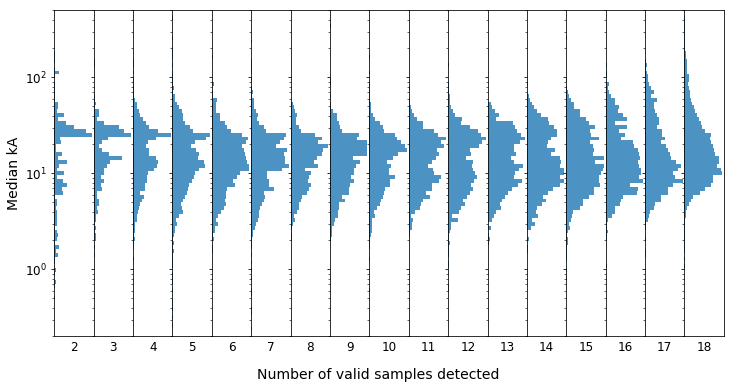

In [9]:
def survey_kA(fittingRes):
    surveyRes = [[[], []] for i in range(18)]
    for res in fittingRes:
        if len(res['stdevs'])>1:
            surveyRes[np.sum(res['config'])-1][0].append(res['params'][2])
            surveyRes[np.sum(res['config'])-1][1].append(res['ci95'][2][1])
    return surveyRes

def precision_plot(surveyRes):
    import matplotlib.pyplot as plt
    import plot
    
    lowest = 0.1
    highest = 1000

    fig,ax = plt.subplots(1, 17, figsize=[12,6], sharey=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    bins = np.logspace(np.log10(lowest), np.log10(highest), 100)
    for i in range(17):
        res = surveyRes[i+1]
        ax[i].hist(res[1], bins=bins, alpha=0.8, density=False, orientation='horizontal')
        ax[i].set_yscale('log')
        ax[i].set_ylim([0.2, 500])
        plot.set_ticks_size(ax[i])
        ax[i].set_xticks([])
        ax[i].set_xlabel(str(i+2), fontsize=12)
    ax[0].set_ylabel('Median kA', fontsize=14)
    fig.text(s='Number of valid samples detected', x=0.5, y=0.02, ha='center', va='bottom', fontsize=14)
    
    # fig.savefig('/home/yuning/Work/ribozyme_pred/fig/ci_est/bto_res_precision_pctci95.png', dpi=300)
    plt.show()
    
surveyRes = survey_kA(fittingResNew)
precision_plot(surveyRes)

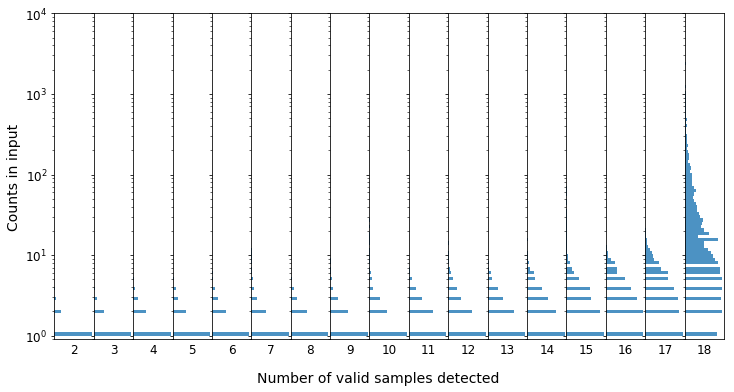

In [146]:
def survey_kA(fittingRes):
    surveyRes = [[[], []] for i in range(18)]
    for res in fittingRes:
        if len(res['stdevs'])>1:
            surveyRes[np.sum(res['config'])-1][0].append(res['params'][2])
            surveyRes[np.sum(res['config'])-1][1].append(res['ng'][0]/0.00019080410095254175)
    return surveyRes

def precision_plot(surveyRes):
    import matplotlib.pyplot as plt
    import plot
    
    lowest = 1
    highest = 10000

    fig,ax = plt.subplots(1, 17, figsize=[12,6], sharey=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    bins = np.logspace(np.log10(lowest), np.log10(highest), 100)
    for i in range(17):
        res = surveyRes[i+1]
        ax[i].hist(res[1], bins=bins, alpha=0.8, density=False, orientation='horizontal')
        ax[i].set_yscale('log')
        ax[i].set_ylim([0.9, 10000])
        plot.set_ticks_size(ax[i])
        ax[i].set_xticks([])
        ax[i].set_xlabel(str(i+2), fontsize=12)
    ax[0].set_ylabel('Counts in input', fontsize=14)
    fig.text(s='Number of valid samples detected', x=0.5, y=0.02, ha='center', va='bottom', fontsize=14)
    
    # fig.savefig('/home/yuning/Work/ribozyme_pred/fig/ci_est/bto_res_precision_pctci95.png', dpi=300)
    plt.show()
    
# surveyRes = survey_kA(fittingResNew)
precision_plot(surveyRes)

In [148]:
def sort_fn(seq):
    if len(seq['ci95'])==3:
        return seq['ci95'][2][1]
    else:
        return 0

fittingResNewSorted = fittingResNew.copy()
fittingResNewSorted.sort(key=sort_fn, reverse=True)

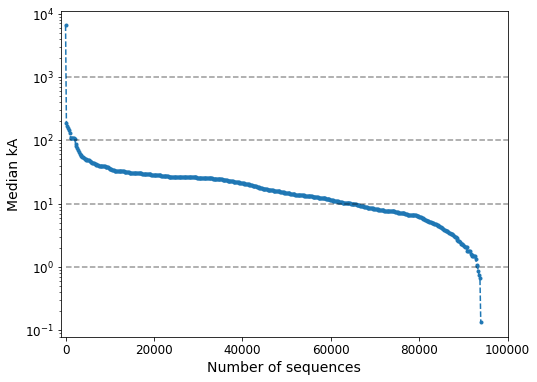

In [202]:
# samplePoint = [int(i) for i in np.logspace(0, np.log10(93943), 25)]
samplePoint = [int(i) for i in np.linspace(0, 93942, 500)]
kASeries = [fittingResNewSorted[i]['ci95'][2][1] for i in samplePoint]

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)
ax.plot(samplePoint, kASeries, '.--')
for i in range(4):
    ax.plot([0, 10**5], [10**i, 10**i], 'k--', alpha=0.4)
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([-1000, 10**5])
plot.set_ticks_size(ax)
ax.set_xlabel('Number of sequences', fontsize=14)
ax.set_ylabel('Median kA', fontsize=14)
plt.show()

In [38]:
fittingResNewFiltered[0]

{'ci95': array([[2.41955479e-01, 3.04504092e-01, 3.92781749e-01, 3.08353643e-01],
        [5.10863517e+02, 1.30867034e+03, 2.44213936e+03, 1.31387808e+03],
        [1.82986073e+02, 3.91099501e+02, 6.62404892e+02, 3.92723105e+02]]),
 'config': [6, 5, 3, 4],
 'ng': [0.00019080410095254175,
  4.988791436322038e-05,
  3.9087968495574605e-05,
  4.364394137467166e-05,
  3.155930590139568e-05,
  3.660156984225481e-05,
  0.00012034591158623673,
  3.681300323543531e-05,
  6.676264026025085e-05,
  0,
  5.970595349297725e-05,
  4.46066775277684e-05,
  5.571194001118596e-05,
  2.6585018967371802e-05,
  1.645100500969604e-05,
  1.9765715437071776e-05,
  2.409816815908596e-05,
  0,
  7.172959064486187e-05,
  8.879875832281056e-06,
  8.148705494333406e-06,
  6.0029521574785016e-06,
  1.5367871847864706e-05,
  7.63121334269162e-06,
  8.073732365531213e-06],
 'params': [0.2853965985401185, 1289.5076961970449, 368.0211102859411],
 'r2': 0.5300600675086331,
 'reactedFrac': array([1.        , 0.26146144, 

In [39]:
fittingResNewFilteredReorg = []
for res in fittingResNewFiltered:
    if ~np.isnan(res['params'][0]):
        fittingResNewFilteredReorg.append({
            'seq': res['seq'],
            'config': res['config'],
            'pointEstimation': {
                'A': res['params'][0],
                'k': res['params'][1],
                'kA': res['params'][2],
            },
            'stddev':{
                'A': res['stdevs'][0],
                'k': res['stdevs'][1],
                'kA': res['stdevs'][2]
            }
        })
        if len(res['ci95'])==3:
            fittingResNewFilteredReorg[-1]['bootstrapRes']={
                'A':{
                    '2.5': res['ci95'][0][0],
                    'median': res['ci95'][0][1],
                    '97.5': res['ci95'][0][2],
                    'mean': res['ci95'][0][3]
                },
                'k':{
                    '2.5': res['ci95'][1][0],
                    'median': res['ci95'][1][1],
                    '97.5': res['ci95'][1][2],
                    'mean': res['ci95'][1][3]
                },
                'kA':{
                    '2.5': res['ci95'][2][0],
                    'median': res['ci95'][2][1],
                    '97.5': res['ci95'][2][2],
                    'mean': res['ci95'][2][3]
                }
            }
        else:
            print('A seq does not estimate its CI')

In [40]:
len(fittingResNewFilteredReorg)

28087

In [42]:
util.dump_pickle(data=fittingResNewFilteredReorg,
                 dirc='/mnt/storage/projects/ribozyme_predict/k_seq/repeat_res/fittingRes_byo_abeData_fix_min6_clean_2.pkl',
                 log='The reorganized fitting results on fittingRes_byo_abeDate_fix_min6.pkl, only prediction relavent data are included. Fixed for the wrong k, A order',
                 overwrite=True)

Data has been saved to /mnt/storage/projects/ribozyme_predict/k_seq/repeat_res/fittingRes_byo_abeData_fix_min6_clean_2.pkl


In [77]:
sort_fn = lambda x:x['bootstrapRes']['kA']['median']

loadedRes.sort(key=sort_fn, reverse=True)

In [84]:
loadedRes[25000]

{'bootstrapRes': {'A': {'2.5': 0.03622701150258465,
   '97.5': 0.9999999999999306,
   'mean': 0.5646864390946935,
   'median': 0.8302659225109937},
  'k': {'2.5': 3.8295915735356356,
   '97.5': 336.1999279294672,
   'mean': 63.206515792670245,
   'median': 10.328708702326447},
  'kA': {'2.5': 3.6570497265894604,
   '97.5': 13.74211463192721,
   'mean': 6.956778669591706,
   'median': 6.012878395344622}},
 'config': [6, 4, 2, 4],
 'pointEstimation': {'A': 0.416580983694374,
  'k': 9.462332487466666,
  'kA': 3.9418277756720967},
 'seq': 'TCTTCAAACATTCGGTCTGGC',
 'stddev': {'A': 0.4412379487457616,
  'k': 98.673455065203,
  'kA': 3.035260730553438}}

In [97]:
fittingResNew[0]

{'ci95': [nan],
 'config': [1, 0, 0, 0],
 'ng': [0.00019080410095254175,
  0,
  0,
  0,
  0,
  0,
  1.504323894827959e-05,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'params': [0.8533209179924783, 8.995066242955538, 7.675678183841973],
 'r2': -inf,
 'reactedFrac': array([1.        ,        nan,        nan,        nan,        nan,
               nan, 0.07884128,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan]),
 'seq': 'GGGGGGAGAAGTTAATGG',
 'stdevs': [nan]}

## Add convergence test

In [23]:
import util

fittingRes = util.load_pickle('/mnt/storage/projects/ribozyme_predict/k_seq/repeat_res/fittingRes_byo_abeData_fix_add_converge.pkl')
fittingResFiltered = [seq for seq in fittingRes if np.sum(seq['config'])>=6]

In [25]:
import numpy as np

def get_PMAD(seq):
    return (
        np.median(np.absolute(seq['convergTest']['A'] - np.median(seq['convergTest']['A'])))/np.median(seq['convergTest']['A']),
        np.median(np.absolute(seq['convergTest']['k'] - np.median(seq['convergTest']['k'])))/np.median(seq['convergTest']['k']),
        np.median(np.absolute(seq['convergTest']['kA'] - np.median(seq['convergTest']['kA'])))/np.median(seq['convergTest']['kA']),
    )


for seq in fittingRes:
    seq['convergPMAD'] = {}
    (seq['convergPMAD']['A'], seq['convergPMAD']['k'], seq['convergPMAD']['kA']) = get_PMAD(seq)
for seq in fittingResFiltered:
    seq['convergPMAD'] = {}
    (seq['convergPMAD']['A'], seq['convergPMAD']['k'], seq['convergPMAD']['kA']) = get_PMAD(seq)

In [74]:
len(fittingResFiltered)

28132

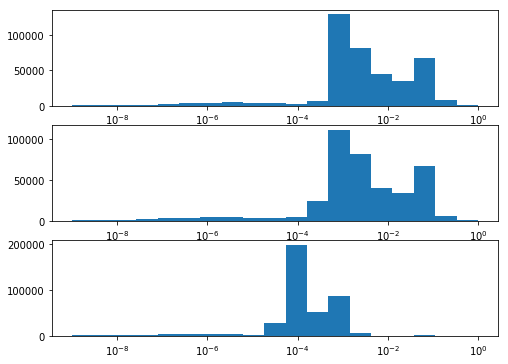

In [27]:
import matplotlib.pyplot as plt

def plot_PMAD_dist(fittingRes):
    
    fig, axes = plt.subplots(3,1,figsize=[8,6])
    bins = np.logspace(-9, 0, 20)
    axes[0].hist([seq['convergPMAD']['k'] for seq in fittingRes], bins=bins)
    axes[0].set_xscale('log')
    axes[1].hist([seq['convergPMAD']['A'] for seq in fittingRes], bins=bins)
    axes[1].set_xscale('log')
    bins = np.logspace(-9, 0, 20)
    axes[2].hist([seq['convergPMAD']['kA'] for seq in fittingRes], bins=bins)
    axes[2].set_xscale('log')
    
    plt.show()
    
plot_PMAD_dist(fittingRes)

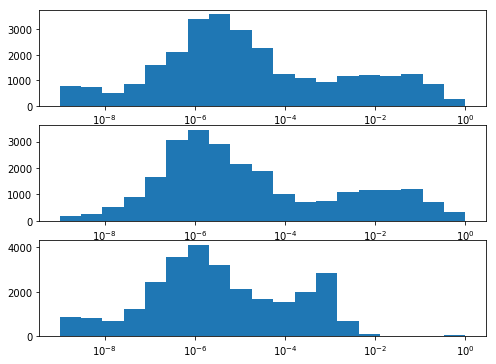

In [28]:
plot_PMAD_dist(fittingResFiltered)

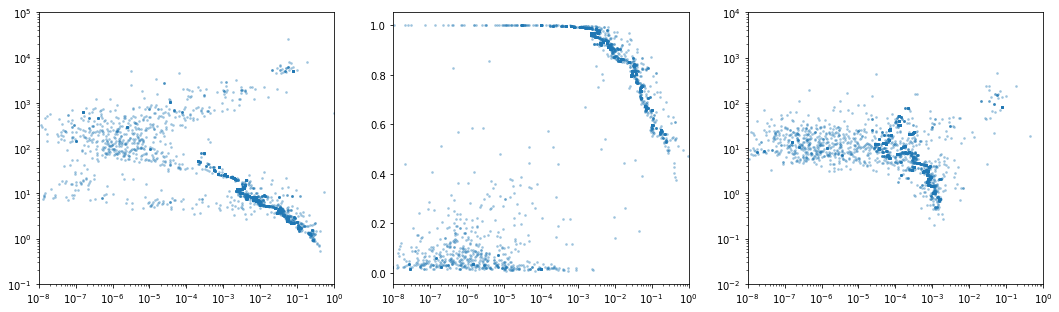

In [55]:
def plot_PMAD_scatter(fittingRes, subsample=None):
    fig, axes = plt.subplots(1,3,figsize=[18,5])
    if subsample:
        subsample = np.random.choice(fittingRes, replace=False, size=subsample)
    else:
        subsample = fittingRes
    axes[0].scatter([seq['convergPMAD']['k'] for seq in subsample], [np.median(seq['convergTest']['k']) for seq in subsample], s=3, alpha=0.3)
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')
    axes[0].set_xlim(10**-8, 1)
    axes[0].set_ylim(10**-1, 10**5)
    axes[1].scatter([seq['convergPMAD']['A'] for seq in subsample], [np.median(seq['convergTest']['A']) for seq in subsample], s=3, alpha=0.3)
    axes[1].set_xscale('log')
    axes[1].set_xlim(10**-8, 1)
    axes[2].scatter([seq['convergPMAD']['kA'] for seq in subsample], [np.median(seq['convergTest']['kA']) for seq in subsample], s=3, alpha=0.3)
    axes[2].set_xscale('log')
    axes[2].set_yscale('log')
    axes[2].set_xlim(10**-8, 1)
    axes[2].set_ylim(10**-2, 10**4)
    plt.show()
    
plot_PMAD_scatter(fittingRes, subsample=10000)

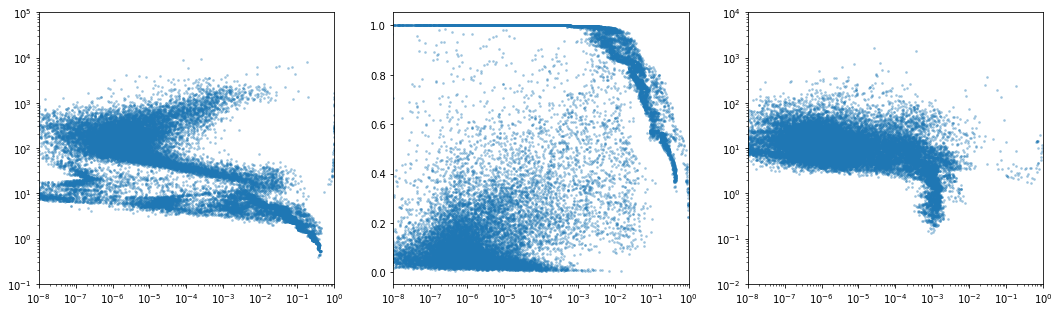

In [56]:
plot_PMAD_scatter(fittingResFiltered)

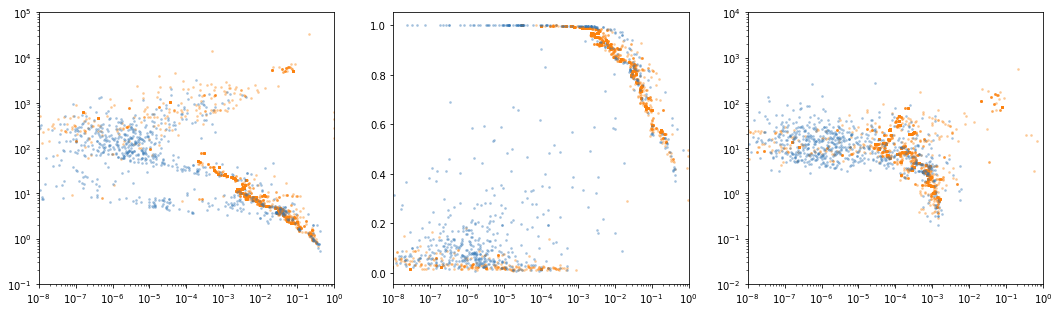

In [76]:
def plot_PMAD_scatter_seperated(fittingRes, subsample=None):
    fig, axes = plt.subplots(1,3,figsize=[18,5])
    if subsample:
        subsample = np.random.choice(fittingRes, replace=False, size=subsample)
    else:
        subsample = fittingRes
    subsampleDense = [seq for seq in subsample if np.sum(seq['config']) >= 6]
    subsampleSparse = [seq for seq in subsample if np.sum(seq['config']) < 6]
    axes[0].scatter([seq['convergPMAD']['k'] for seq in subsampleSparse], [np.median(seq['convergTest']['k']) for seq in subsampleSparse], s=3, alpha=0.3, color='#FC820D')
    axes[0].scatter([seq['convergPMAD']['k'] for seq in subsampleDense], [np.median(seq['convergTest']['k']) for seq in subsampleDense], s=3, alpha=0.3, color='#2C73B4')
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')
    axes[0].set_xlim(10**-8, 1)
    axes[0].set_ylim(10**-1, 10**5)
    axes[1].scatter([seq['convergPMAD']['A'] for seq in subsampleSparse], [np.median(seq['convergTest']['A']) for seq in subsampleSparse], s=3, alpha=0.3, color='#FC820D')
    axes[1].scatter([seq['convergPMAD']['A'] for seq in subsampleDense], [np.median(seq['convergTest']['A']) for seq in subsampleDense], s=3, alpha=0.3, color='#2C73B4')
    axes[1].set_xscale('log')
    axes[1].set_xlim(10**-8, 1)
    axes[2].scatter([seq['convergPMAD']['kA'] for seq in subsampleSparse], [np.median(seq['convergTest']['kA']) for seq in subsampleSparse], s=3, alpha=0.3, color='#FC820D')
    axes[2].scatter([seq['convergPMAD']['kA'] for seq in subsampleDense], [np.median(seq['convergTest']['kA']) for seq in subsampleDense], s=3, alpha=0.3, color='#2C73B4')
    axes[2].set_xscale('log')
    axes[2].set_yscale('log')
    axes[2].set_xlim(10**-8, 1)
    axes[2].set_ylim(10**-2, 10**4)
    plt.show()
    
plot_PMAD_scatter_seperated(fittingRes, subsample=10000)

In [47]:
selectedSeq = [seq for seq in fittingResFiltered if seq['convergPMAD']['k'] >= 10**-2 and np.median(seq['convergTest']['k']) >= 10**2]
print(len(selectedSeq))

59


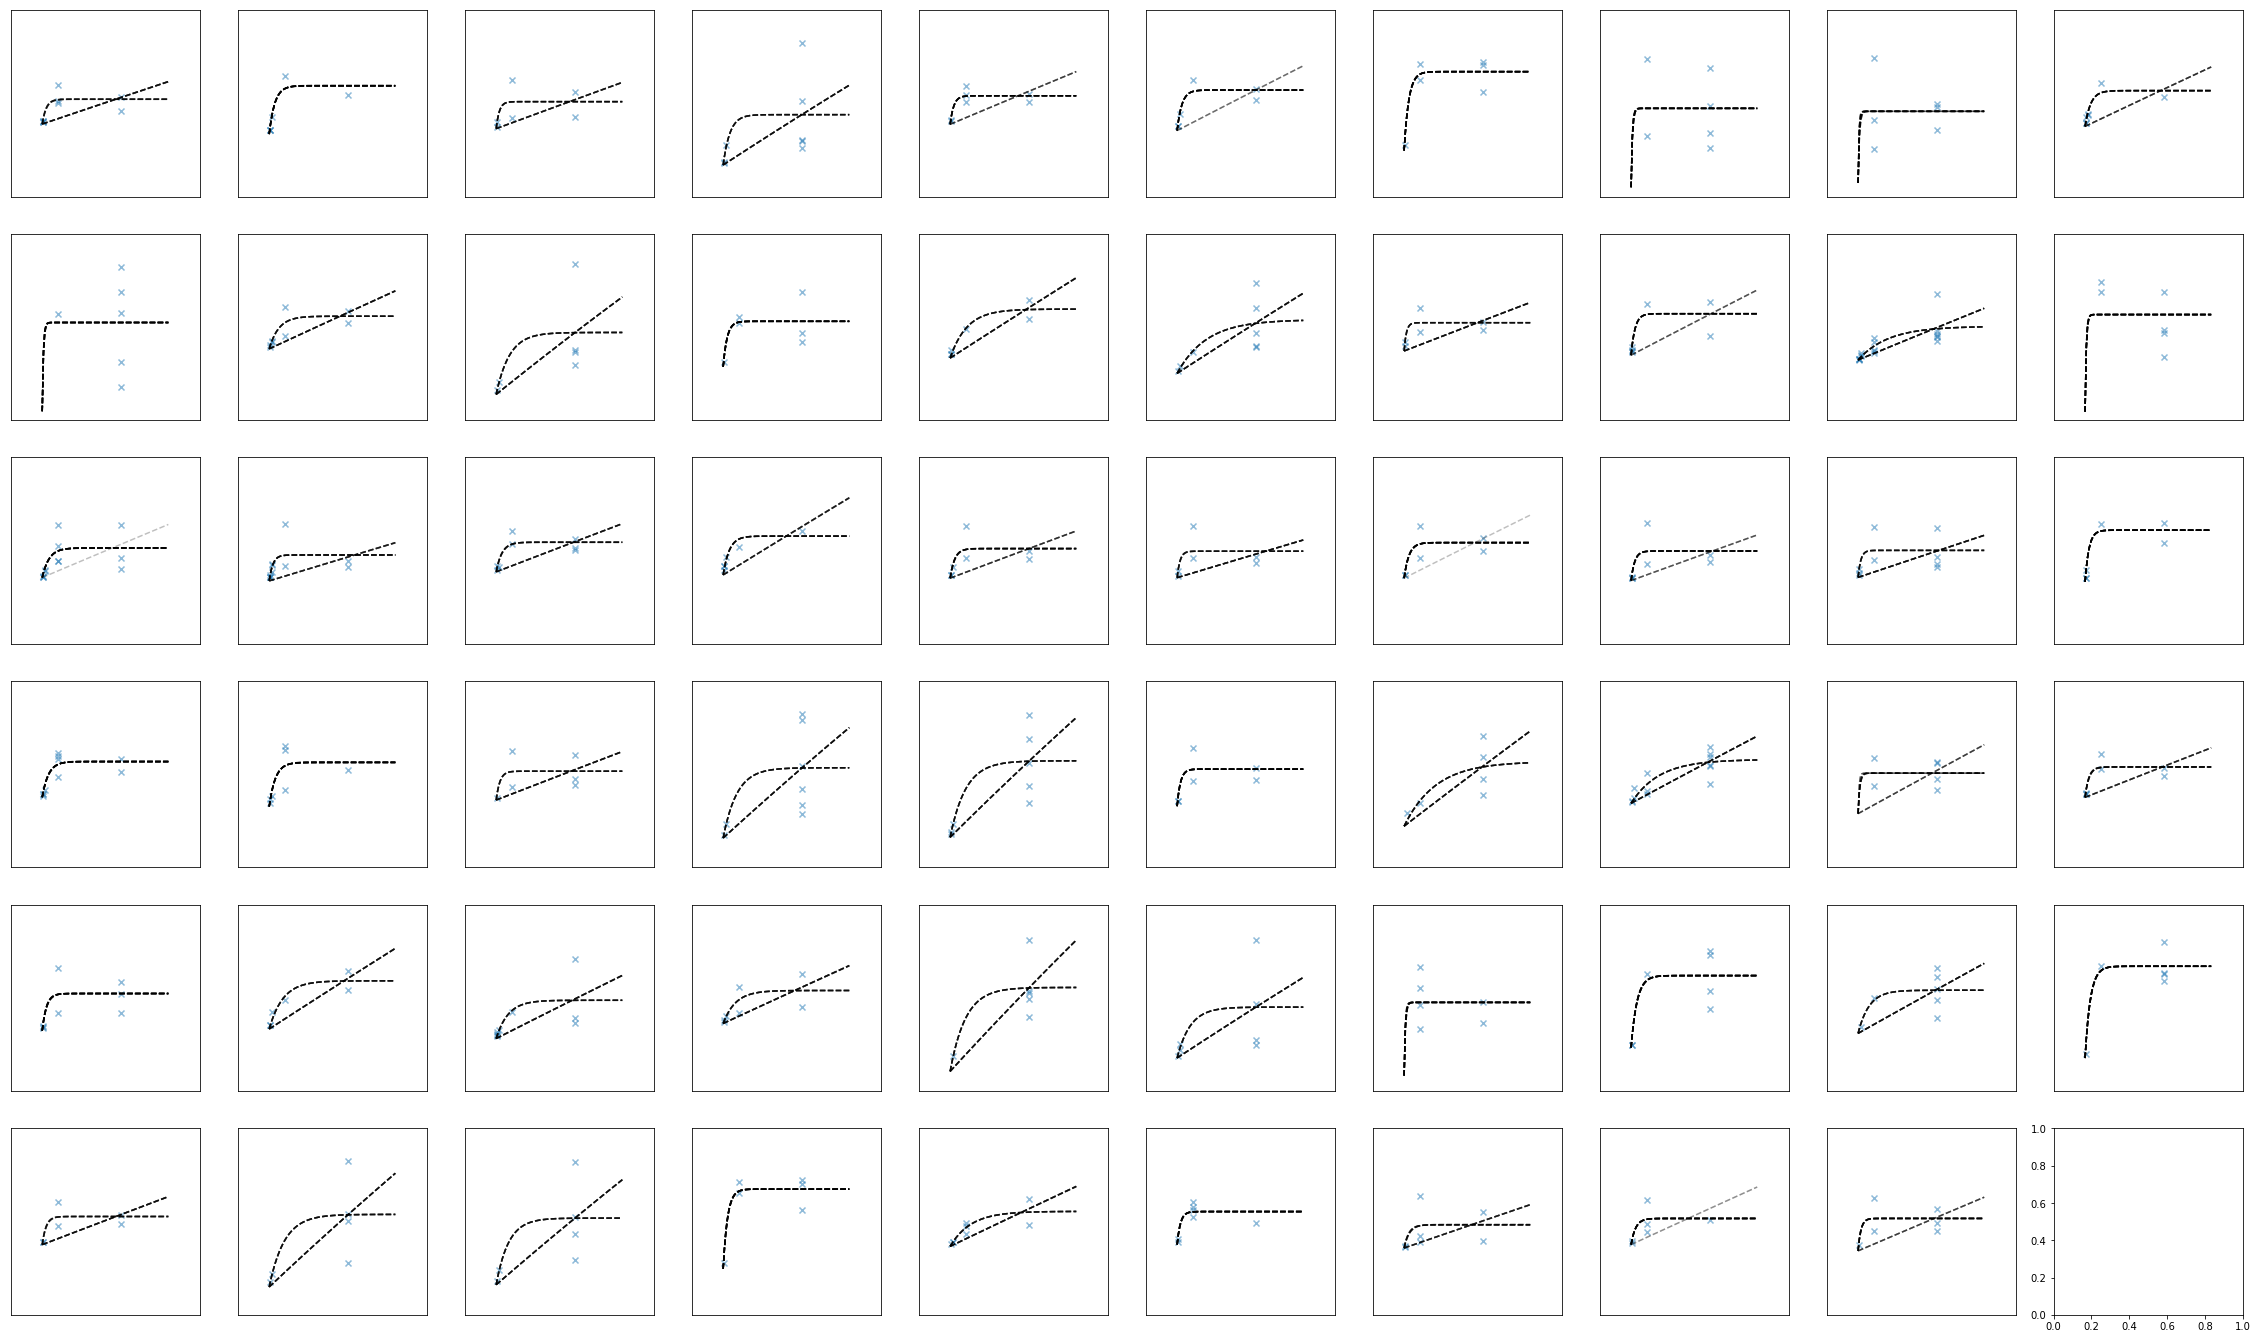

In [52]:
def plot_fitting(seq, ax):
    def exp_func(x, A, k):
        return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BTO degradation adjustment and 90 minutes

    xdata = np.array([0.00025 for i in range(6)] + 
                     [0.00005 for i in range(6)] +
                     [0.00001 for i in range(6)] +
                     [0.000002 for i in range(6)])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(xdata, seq['reactedFrac'][1:], marker='x', alpha=0.5)
    x = np.arange(0, 0.00040, 0.0004/100)
    for i in range(20):
        ax.plot(x, exp_func(x, seq['convergTest']['A'][i], seq['convergTest']['k'][i]), 'k--', alpha=0.25)
    ax.set_xlim([-0.0001, 0.0005])


fig,axes = plt.subplots(6, 10, figsize=[40, 24])
for ix in range(59):
    ax = axes[int(ix/10), ix%10]
    plot_fitting(selectedSeq[ix], ax)
plt.show()

31


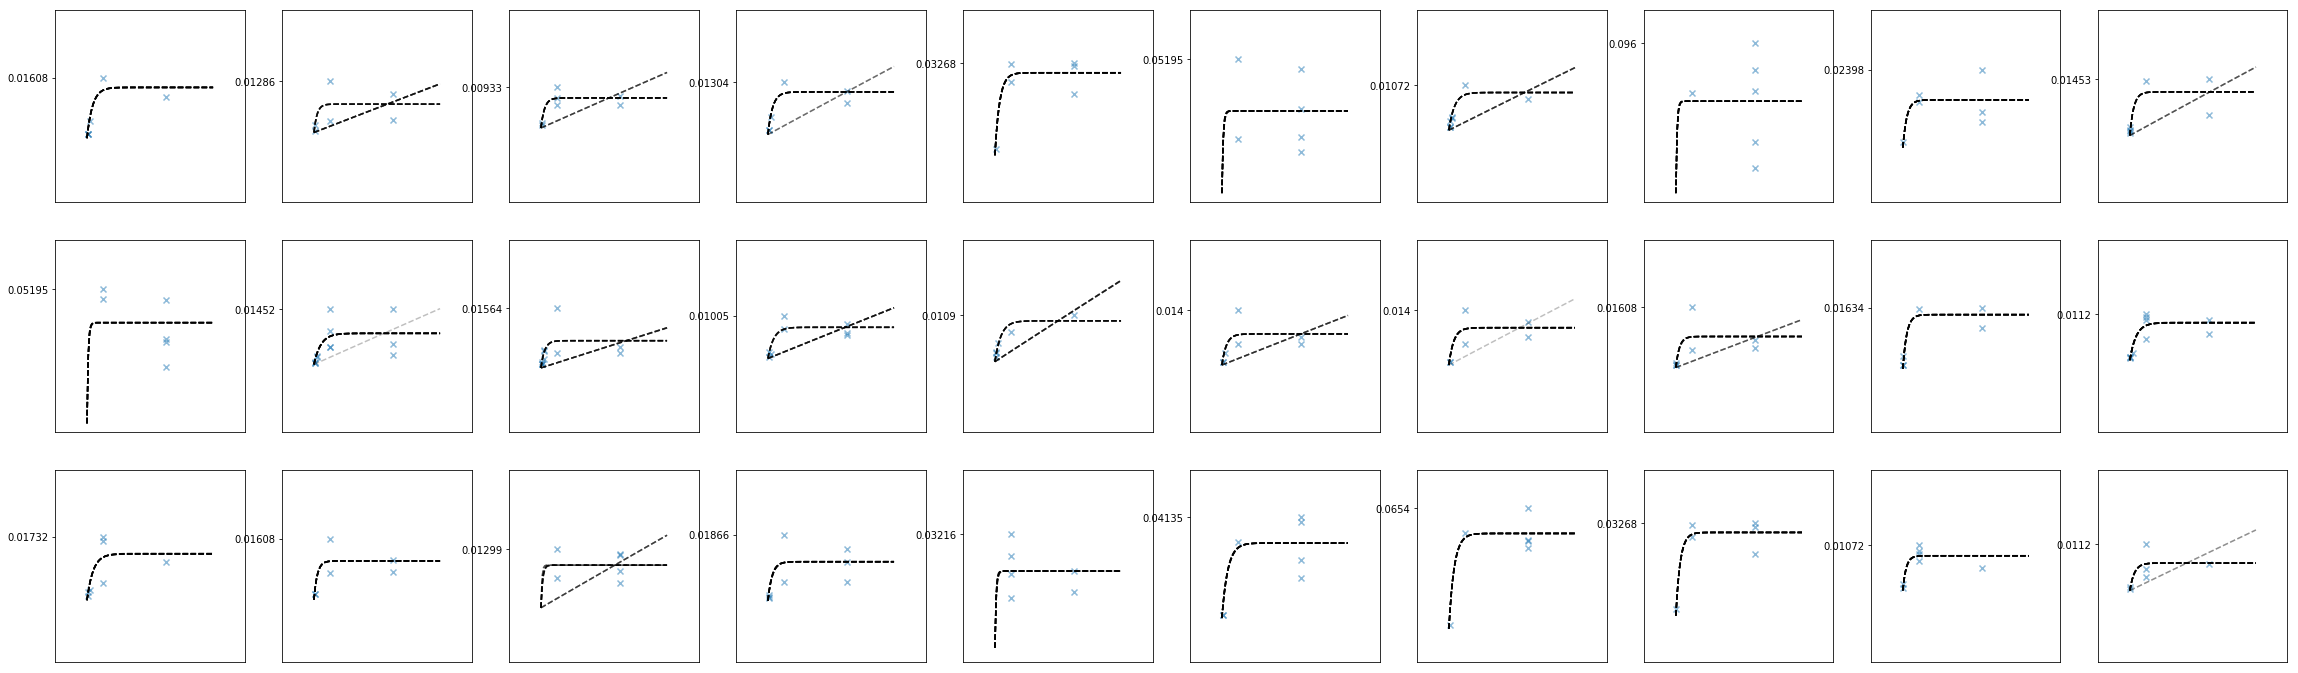

In [62]:
selectedSeq = [seq for seq in fittingResFiltered if (10**-2 <= seq['convergPMAD']['k'] <= 10**-1)and(np.median(seq['convergTest']['k']) >= 10**3)]
print(len(selectedSeq))

def plot_fitting(seq, ax):
    def exp_func(x, A, k):
        return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BTO degradation adjustment and 90 minutes

    xdata = np.array([0.00025 for i in range(6)] + 
                     [0.00005 for i in range(6)] +
                     [0.00001 for i in range(6)] +
                     [0.000002 for i in range(6)])
    ax.set_xticks([])
    ax.set_yticks([np.nanmax(seq['reactedFrac'][1:])])
    ax.scatter(xdata, seq['reactedFrac'][1:], marker='x', alpha=0.5)
    x = np.arange(0, 0.00040, 0.0004/100)
    for i in range(20):
        ax.plot(x, exp_func(x, seq['convergTest']['A'][i], seq['convergTest']['k'][i]), 'k--', alpha=0.25)
    ax.set_xlim([-0.0001, 0.0005])


x=3
y=10
fig,axes = plt.subplots(x, y, figsize=[4*y, 4*x])
for ix in range(30):
    ax = axes[int(ix/10), ix%10]
    plot_fitting(selectedSeq[ix], ax)
plt.show()

949


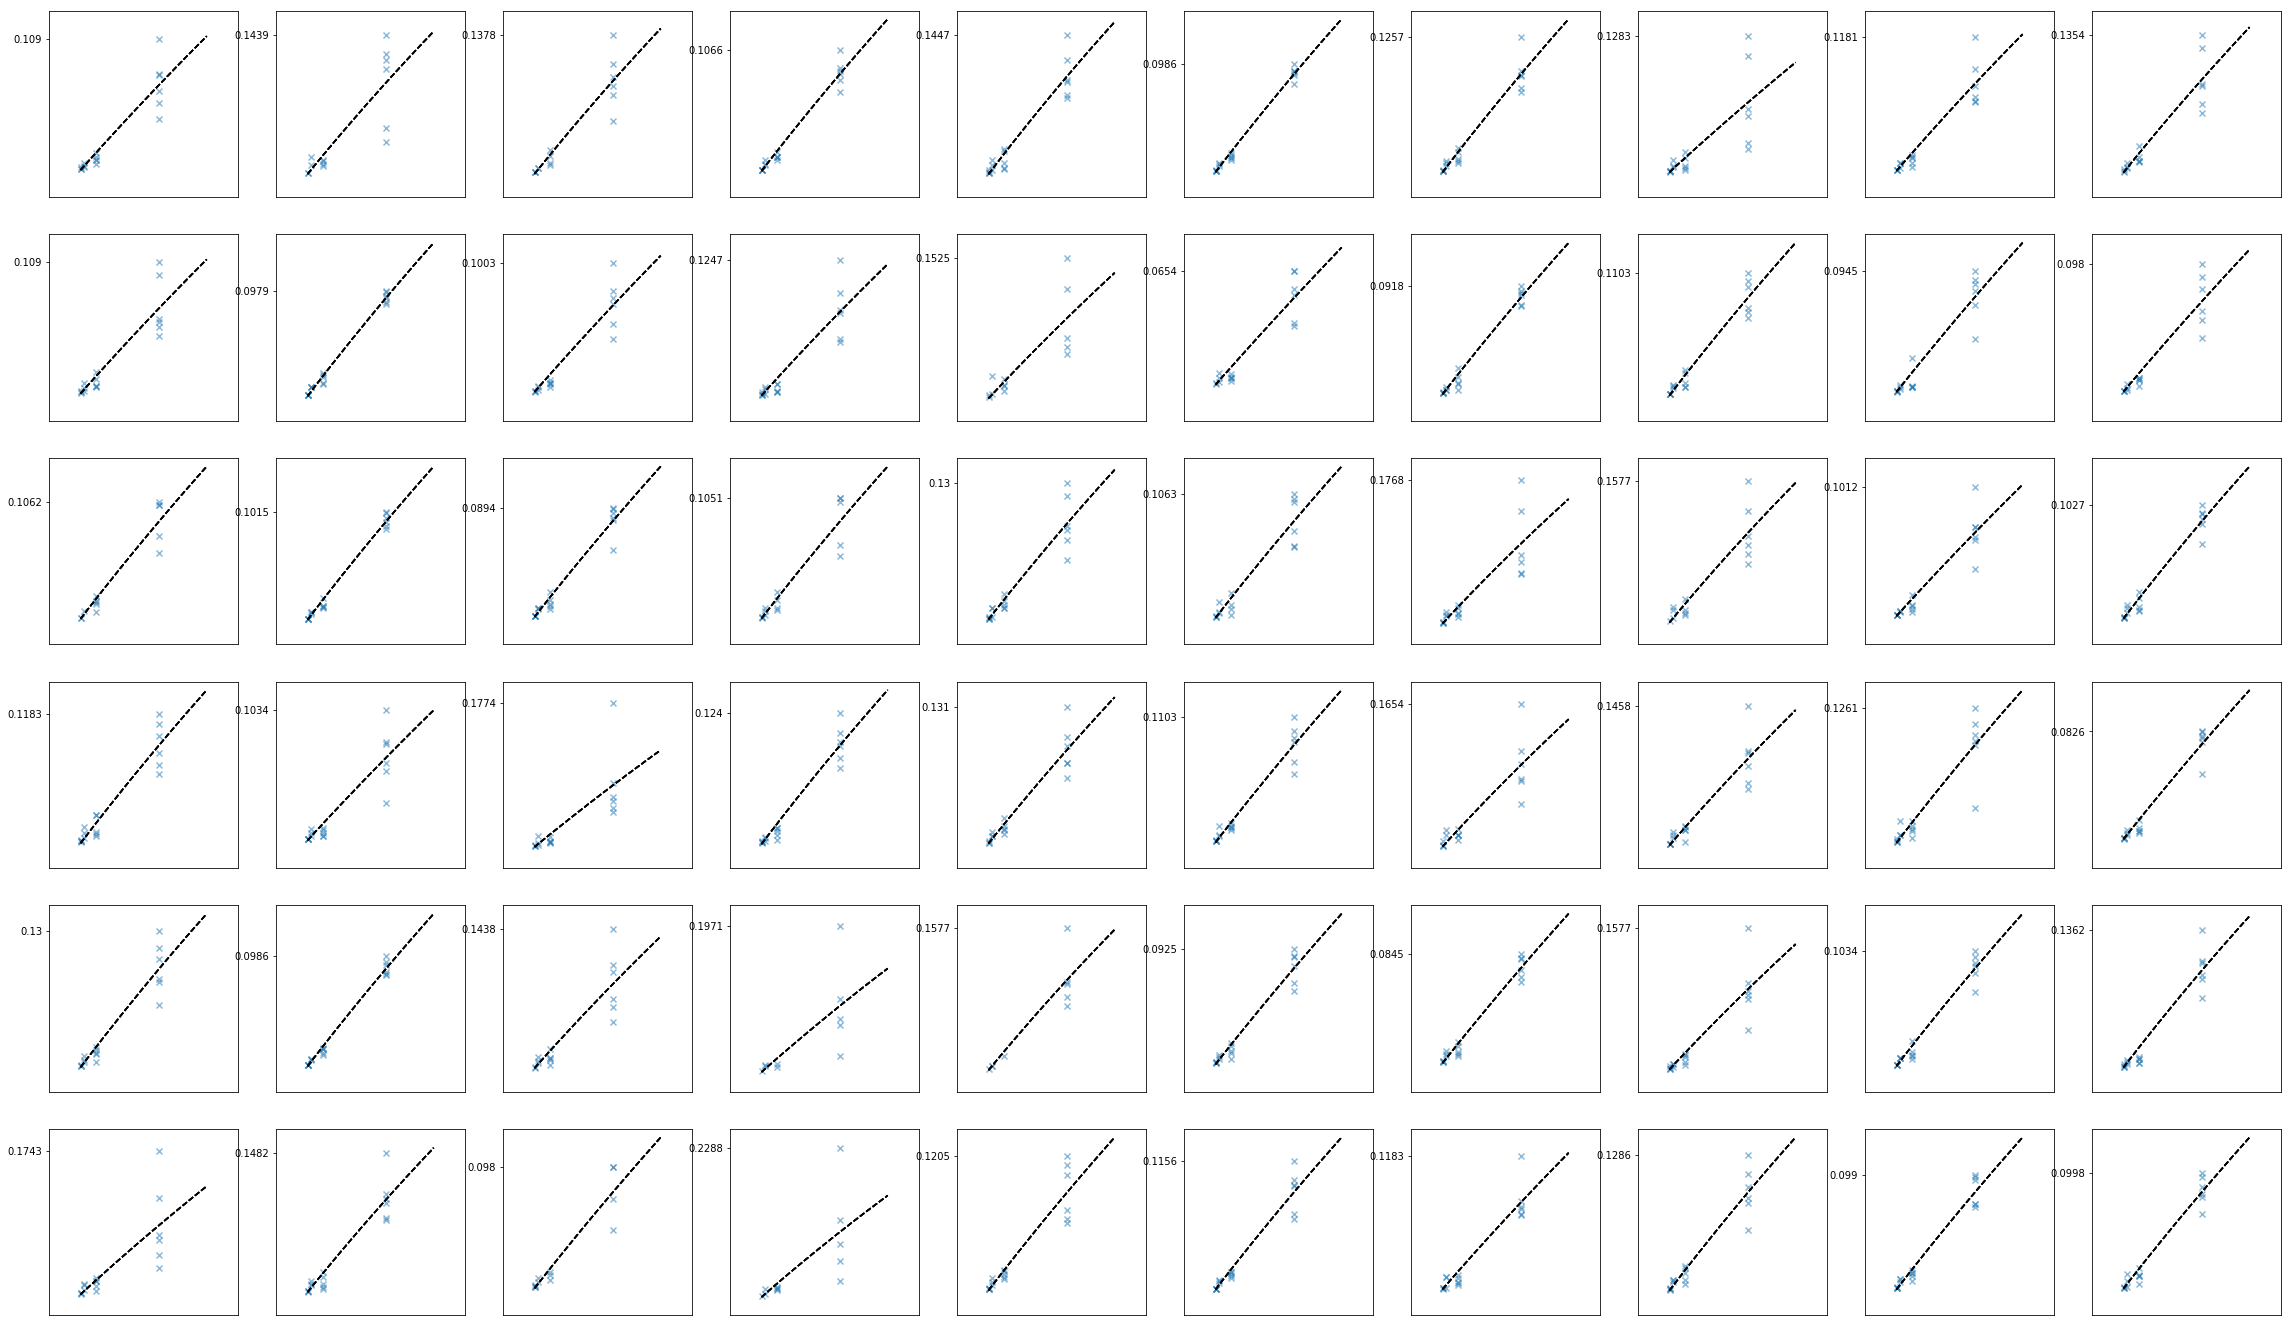

In [65]:
selectedSeq = [seq for seq in fittingResFiltered if (seq['convergPMAD']['k'] <= 10**-6)and(np.median(seq['convergTest']['k']) <= 10)]
print(len(selectedSeq))
selectedSeq = np.random.choice(selectedSeq, replace=False, size=60)

def plot_fitting(seq, ax):
    def exp_func(x, A, k):
        return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BTO degradation adjustment and 90 minutes

    xdata = np.array([0.00025 for i in range(6)] + 
                     [0.00005 for i in range(6)] +
                     [0.00001 for i in range(6)] +
                     [0.000002 for i in range(6)])
    ax.set_xticks([])
    ax.set_yticks([np.nanmax(seq['reactedFrac'][1:])])
    ax.scatter(xdata, seq['reactedFrac'][1:], marker='x', alpha=0.5)
    x = np.arange(0, 0.00040, 0.0004/100)
    for i in range(20):
        ax.plot(x, exp_func(x, seq['convergTest']['A'][i], seq['convergTest']['k'][i]), 'k--', alpha=0.25)
    ax.set_xlim([-0.0001, 0.0005])


x=6
y=10
fig,axes = plt.subplots(x, y, figsize=[4*y, 4*x])
for ix in range(int(x*y)):
    ax = axes[int(ix/10), ix%10]
    plot_fitting(selectedSeq[ix], ax)
plt.show()

3707


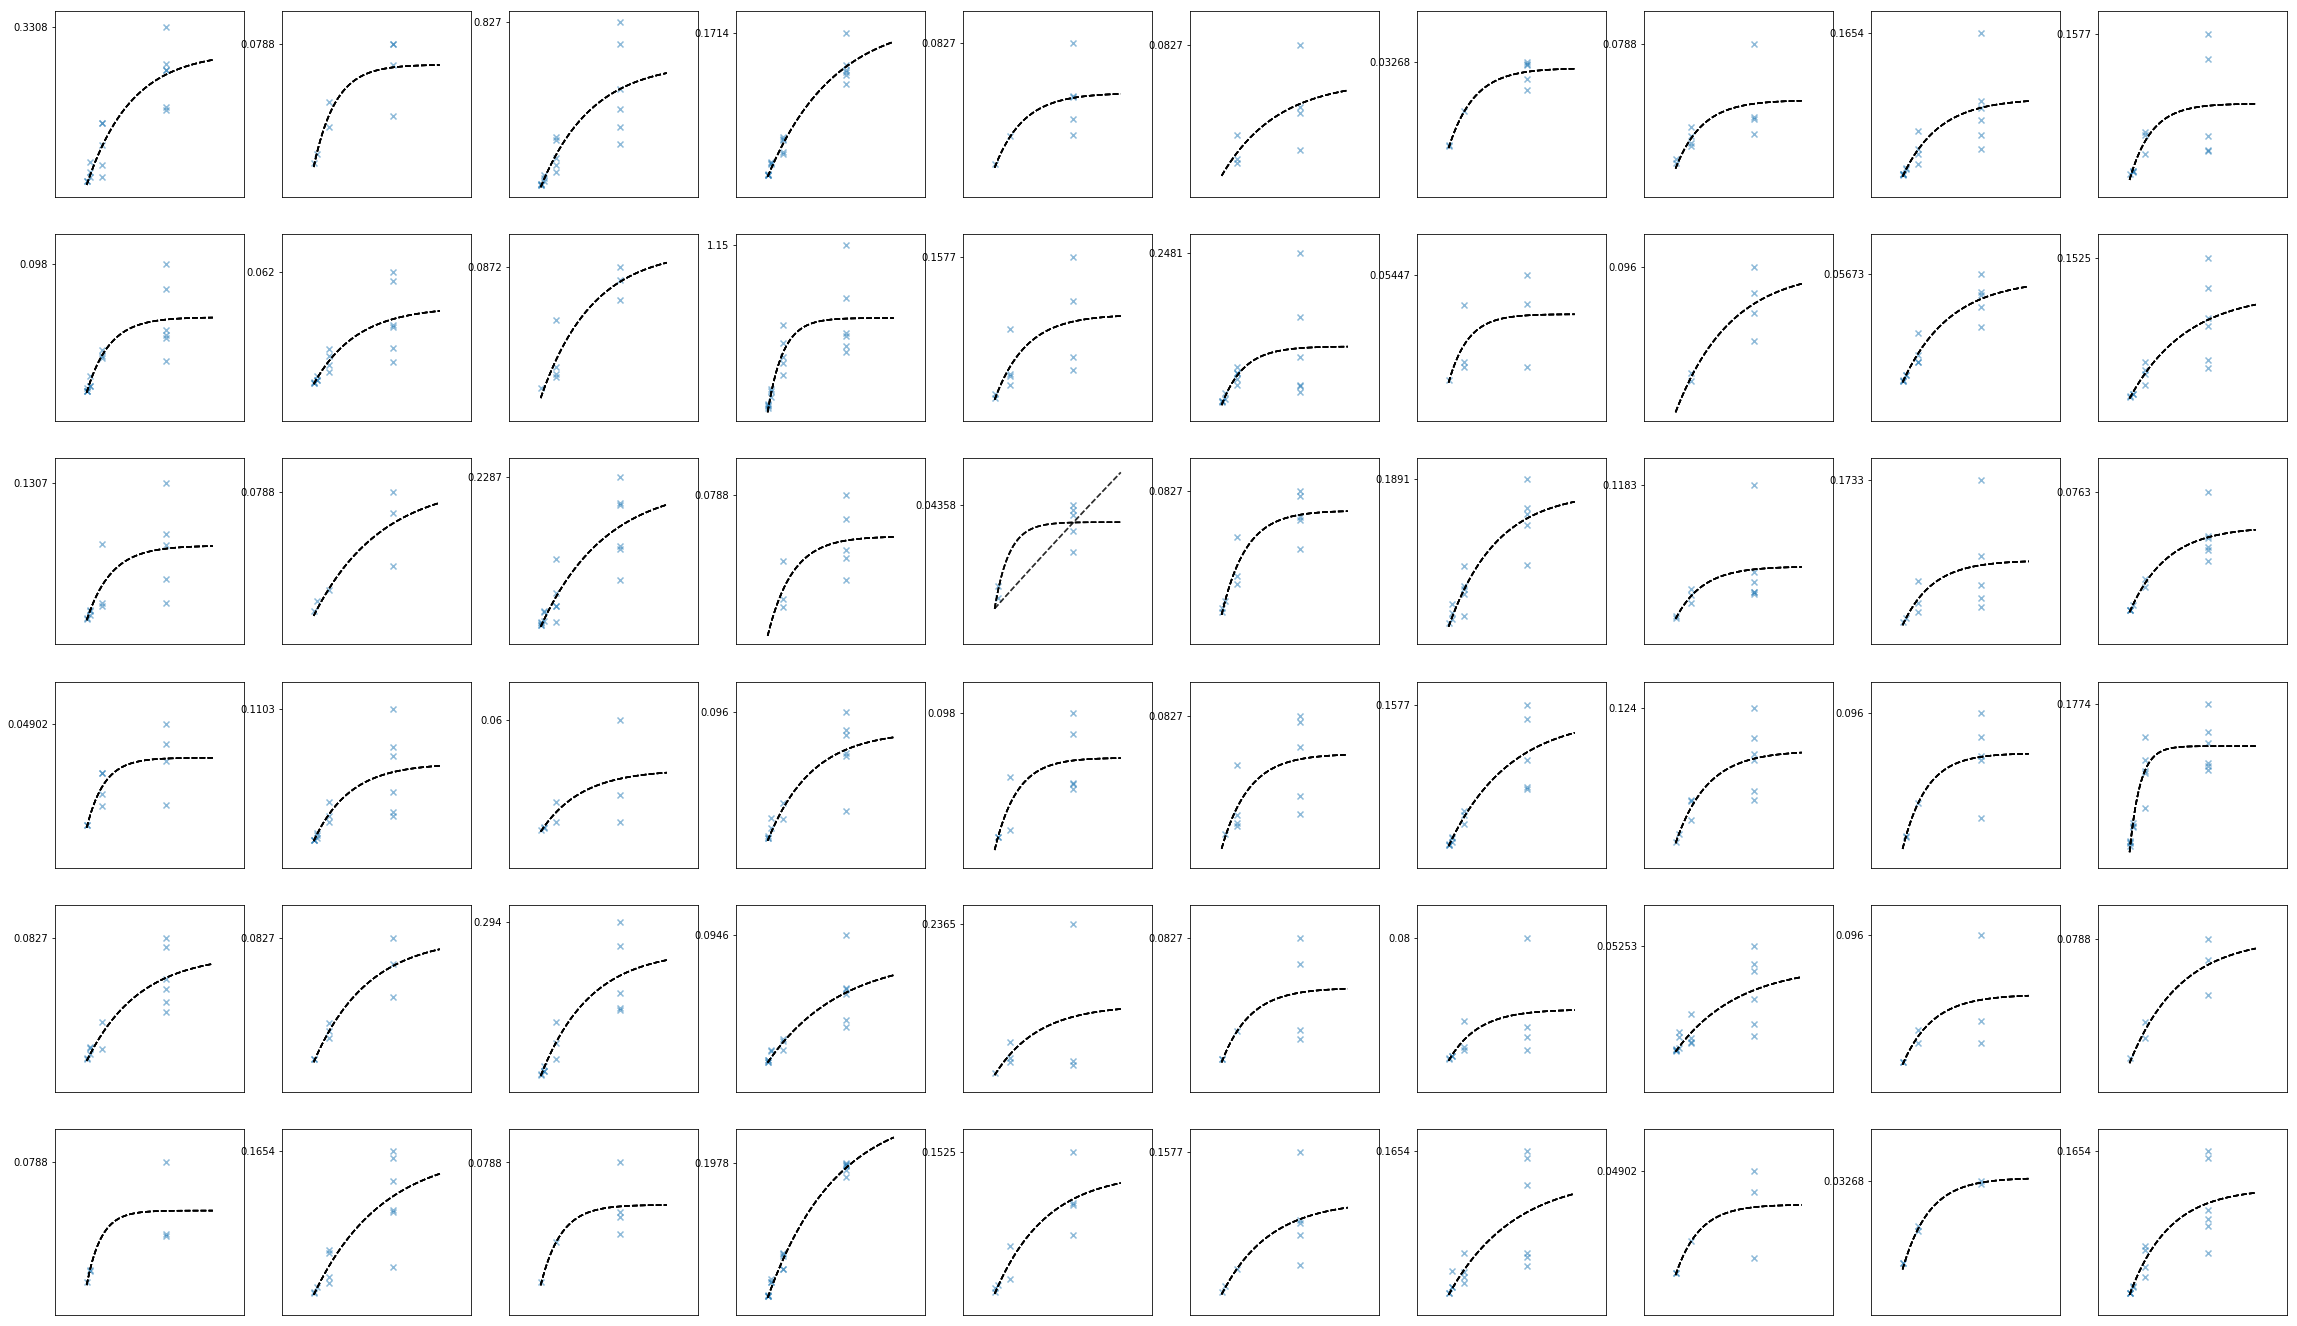

In [66]:
selectedSeq = [seq for seq in fittingResFiltered if (seq['convergPMAD']['k'] <= 10**-6)and(np.median(seq['convergTest']['k']) > 100)]
print(len(selectedSeq))
selectedSeq = np.random.choice(selectedSeq, replace=False, size=60)

def plot_fitting(seq, ax):
    def exp_func(x, A, k):
        return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BTO degradation adjustment and 90 minutes

    xdata = np.array([0.00025 for i in range(6)] + 
                     [0.00005 for i in range(6)] +
                     [0.00001 for i in range(6)] +
                     [0.000002 for i in range(6)])
    ax.set_xticks([])
    ax.set_yticks([np.nanmax(seq['reactedFrac'][1:])])
    ax.scatter(xdata, seq['reactedFrac'][1:], marker='x', alpha=0.5)
    x = np.arange(0, 0.00040, 0.0004/100)
    for i in range(20):
        ax.plot(x, exp_func(x, seq['convergTest']['A'][i], seq['convergTest']['k'][i]), 'k--', alpha=0.25)
    ax.set_xlim([-0.0001, 0.0005])


x=6
y=10
fig,axes = plt.subplots(x, y, figsize=[4*y, 4*x])
for ix in range(int(x*y)):
    ax = axes[int(ix/10), ix%10]
    plot_fitting(selectedSeq[ix], ax)
plt.show()

45


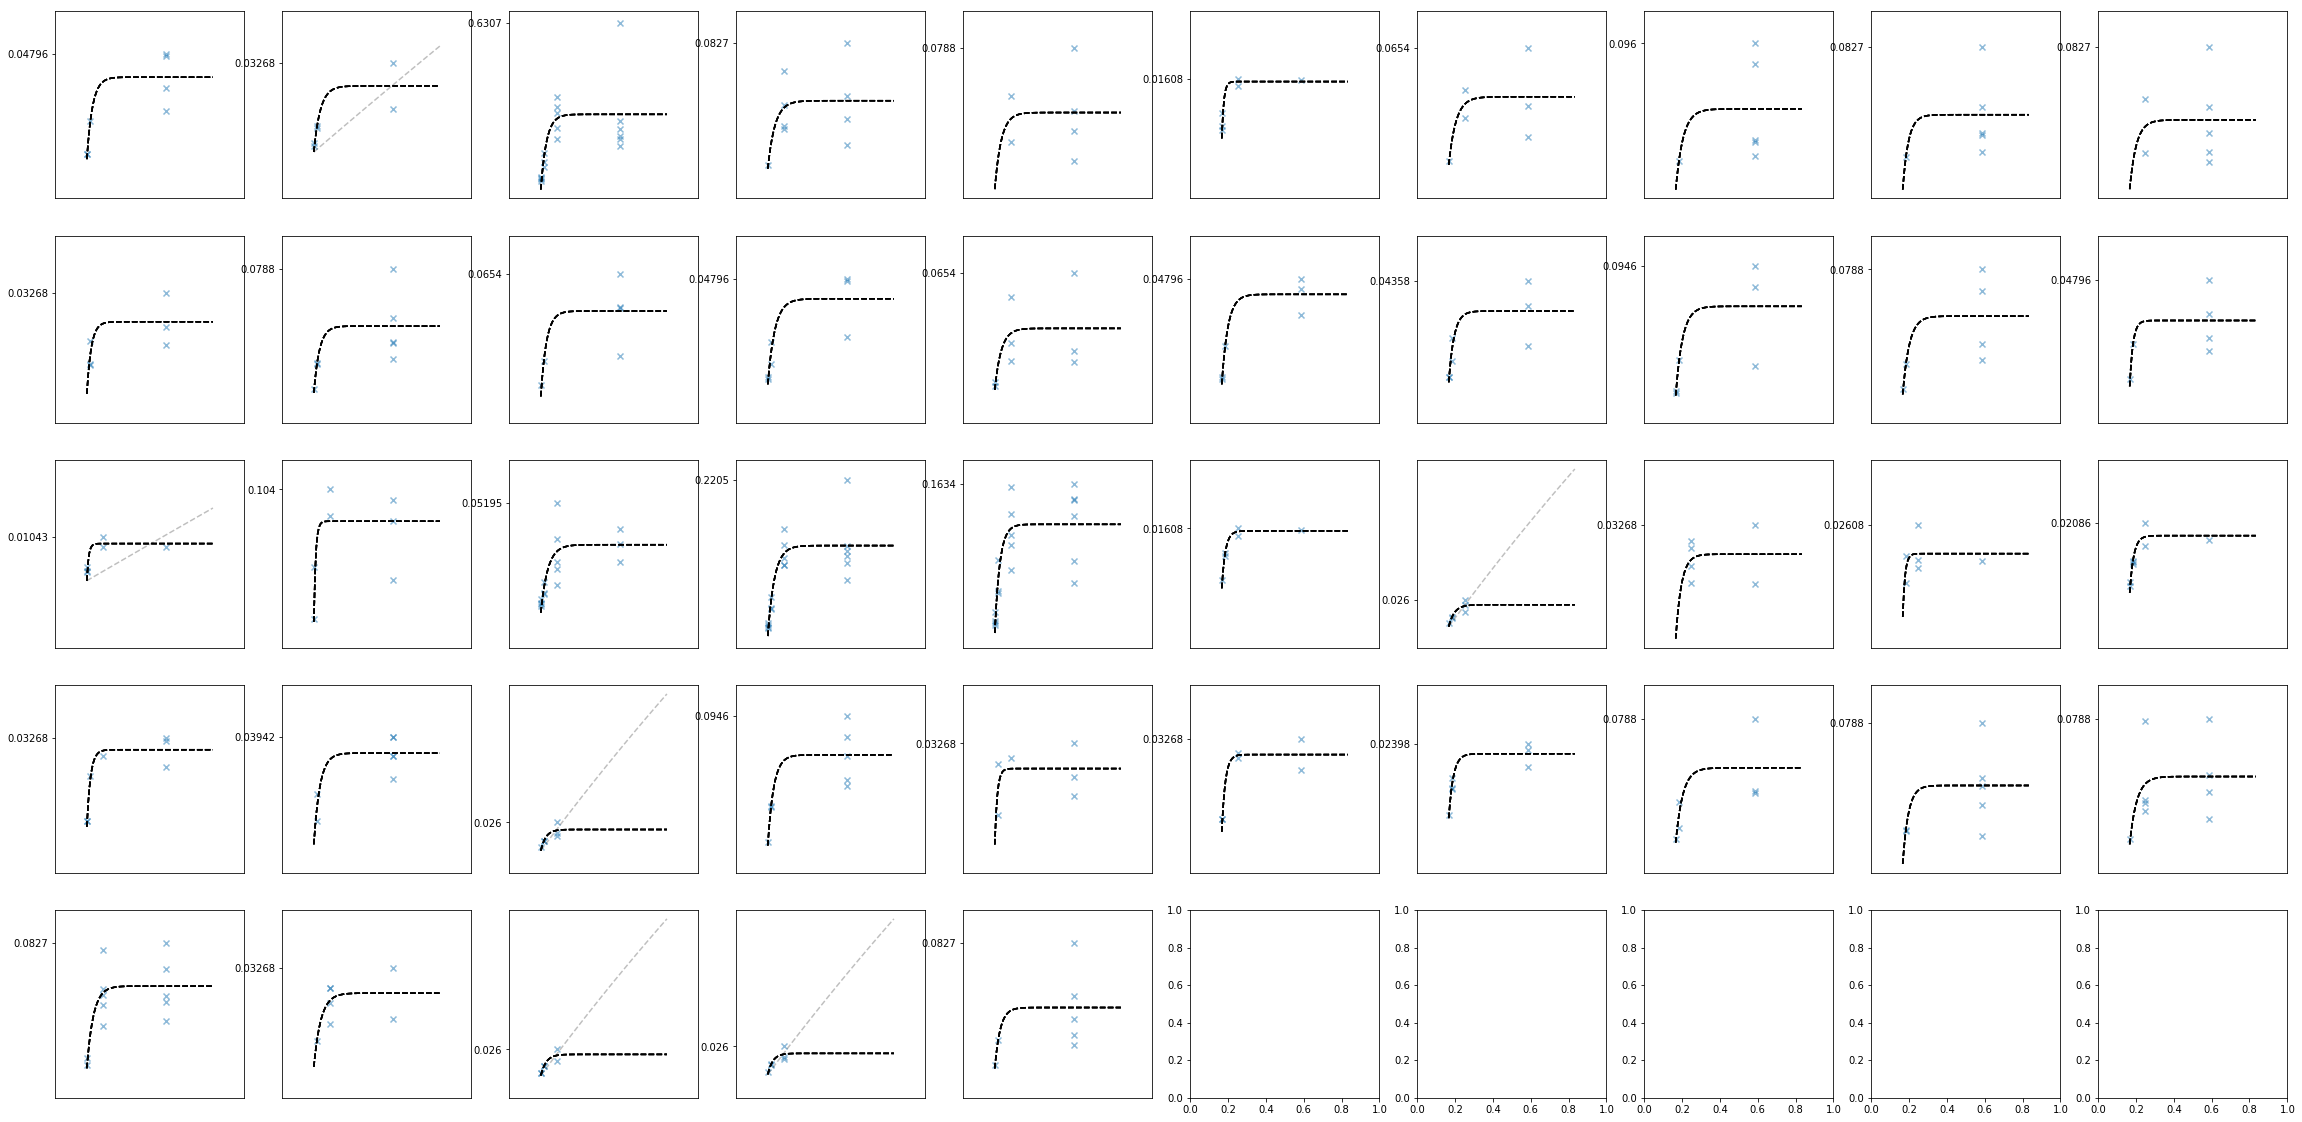

In [69]:
selectedSeq = [seq for seq in fittingResFiltered if (seq['convergPMAD']['k'] <= 10**-5)and(np.median(seq['convergTest']['k']) > 1000)]
print(len(selectedSeq))
# selectedSeq = np.random.choice(selectedSeq, replace=False, size=60)

def plot_fitting(seq, ax):
    def exp_func(x, A, k):
        return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BTO degradation adjustment and 90 minutes

    xdata = np.array([0.00025 for i in range(6)] + 
                     [0.00005 for i in range(6)] +
                     [0.00001 for i in range(6)] +
                     [0.000002 for i in range(6)])
    ax.set_xticks([])
    ax.set_yticks([np.nanmax(seq['reactedFrac'][1:])])
    ax.scatter(xdata, seq['reactedFrac'][1:], marker='x', alpha=0.5)
    x = np.arange(0, 0.00040, 0.0004/100)
    for i in range(20):
        ax.plot(x, exp_func(x, seq['convergTest']['A'][i], seq['convergTest']['k'][i]), 'k--', alpha=0.25)
    ax.set_xlim([-0.0001, 0.0005])

x=5
y=10
fig,axes = plt.subplots(x, y, figsize=[4*y, 4*x])
for ix in range(45):
    ax = axes[int(ix/10), ix%10]
    plot_fitting(selectedSeq[ix], ax)
plt.show()